In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import warnings
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import umap
from umap import UMAP
from scipy.stats import zscore
from functions import *
import tqdm

warnings.filterwarnings('ignore') #supresses warnings for now
#warnings.filterwarnings(action='once') #shows warnings once

dataFilePathClinic = os.path.join(os.getcwd(),'Data')
dataFilePath = os.path.join(os.getcwd(),'Data/genomic_location_files')

colNames = ['chromA', 'startA', 'endA', 'chromB', 'startB', 'endB', 'id', 'dId']

kics_100kb = pd.read_csv(os.path.join(dataFilePath,'kics_te_100kb.bed'), sep = '\t', header = None, names = colNames)
kics_10kb = pd.read_csv(os.path.join(dataFilePath,'kics_te_10_sorted.bed'), sep = '\t', header = None, names = colNames)
kics_1kb = pd.read_csv(os.path.join(dataFilePath,'kics_te_1_sorted.bed'), sep = '\t', header = None, names = colNames)

lfs_100kb = pd.read_csv(os.path.join(dataFilePath,'lfs_te_100_sorted.bed'), sep = '\t', header = None, names = colNames)
lfs_10kb = pd.read_csv(os.path.join(dataFilePath,'lfs_te_10_sorted.bed'), sep = '\t', header = None, names = colNames)
lfs_1kb = pd.read_csv(os.path.join(dataFilePath,'lfs_te_1_sorted.bed'), sep = '\t', header = None, names = colNames)


lfsClinicdf = pd.read_csv(os.path.join(dataFilePathClinic,'lfs_clinical_main.tsv'), sep = '\t', header = 0)
kicsClinicdf = pd.read_csv(os.path.join(dataFilePathClinic,'kics_clinical_edited.csv'), encoding='latin-1')

In [2]:
"""
These variables control which windows to look at
ie want to graph the 100kb, put the kicsWindowFile = kics_100kb
"""

kicsWindowFile = kics_1kb
lfsWindowFile = lfs_1kb

In [3]:
"""
Group and make into matrix
"""
#split the chromA column into just the chrom number (chrom1 -> 1)
#used to sort the entire matrix (the sorted bed file does not work)
def chromFix(row):
    chrom = row['chromA']
    chrom = chrom.replace('chr', '')
    
    #should just be the number or x / y now
    try:
        return int(chrom)
    except:
        return chrom


#creates the matrix of windows, not including the clinical files yet
#pretty sure it's ids across and windows down
def createMatrix (df: pd.DataFrame) -> pd.DataFrame:
    df1 = df.drop(['endA','chromB','startB','endB','dId'],axis=1)
    df1['chromA'] = df1.apply(lambda row: chromFix(row), axis=1)    
    df1['id'] = df1['id'].str.replace(".realigned-recalibrated","")
    
    matrix = df1.groupby(['chromA','startA','id'],sort=False).value_counts().to_frame()
    matrix = matrix.rename(columns={0: 'freq'})
    matrix = matrix.unstack(fill_value = 0)
    matrix.columns = matrix.columns.droplevel()
    
    return matrix

In [4]:
"""
Z-score normalized tables
Normalizes the inputs of the dataframe by columns (windows)
"""
def zScoreNorm(df:pd.DataFrame)->pd.DataFrame:
    df2 = df.transpose()
    df2 = df2.astype('float64')
    df2 = df2.apply(zscore)
    df2 = df2.transpose()
    return df2

In [5]:
"""
Remove samples that only have 1 variation
"""
def cleanMatrix(df:pd.DataFrame) -> pd.DataFrame:
    colRemove = []

    for i in df.columns:
        listUnique = np.unique(df[i].values)
        listUnique = listUnique[listUnique != 0]

        #if the list only has 1 non zero element check if there is only 1 occurrance
        if len(listUnique)<=1:
            sumCol = df[i]
            minimumSum = sum(listUnique)
            sumCol = sumCol.sum()

            if sumCol == minimumSum:
                colRemove.append(i)             

    df2 = df.drop(colRemove,axis=1)
    return df2

In [6]:
"""
quantile transformation center z score were suggestions and ideas 
"""

'\nquantile transformation center z score were suggestions and ideas \n'

# CLEANING

In [7]:
"""
Kics clinic df cleaning
"""
listValSearch = ['63', '83', '156', '171', '219', '120', '141', '232']

kicsClinicdf['KiCS ID'] = kicsClinicdf['KiCS ID'].astype(str)
kicsClinicdf['KiCS ID'] = kicsClinicdf['KiCS ID'].str.replace(" ", "")

for i in listValSearch:
    kicsClinicdf.drop(kicsClinicdf[kicsClinicdf['KiCS ID']==i].index, inplace = True)

kicsClinicdf.drop(kicsClinicdf.loc[kicsClinicdf['tissue_type']=='?'].index, inplace=True)
kicsClinicdf.drop(kicsClinicdf.loc[pd.isna(kicsClinicdf['lfs_cancer_type_diagnosis'])].index, inplace=True)

In [8]:
UberbigKDf = kIdAbbv(kicsClinicdf.copy(), kicsWindowFile.copy(), 'CCP germline', 'id')
UberbigKDf=UberbigKDf.rename(columns={'lfs_cancer_type_diagnosis': 'cancer_diagnosis', 'diagnosis_age (days)':'ageofonset'})
UberbigKDf['ageofonset'] = UberbigKDf['ageofonset'].astype('float')
UberbigKDf['ageofonset'] = UberbigKDf.apply(lambda row:ageOfOnsetKics(row) ,axis=1)

#prints out how many we had before the id matching and how many we have left after the id matching

80


In [9]:
"""
Lfs clinic df cleaning
"""
lfsClinicdf['sample'] = lfsClinicdf['sample'].astype(str)
lfsClinicdf['sample'] = lfsClinicdf['sample'].str.replace(" ", "")

for i in listValSearch:
    lfsClinicdf.drop(lfsClinicdf[lfsClinicdf['sample']==i].index, inplace = True)
        
lfsClinicdf.drop(lfsClinicdf.loc[lfsClinicdf['tissue_type']=='?'].index, inplace=True)
lfsClinicdf.drop(lfsClinicdf.loc[pd.isna(lfsClinicdf['cancer_diagnosis'])].index, inplace=True)

In [10]:
lfsClinicdf['sample'] = lfsClinicdf['sample'].astype(str)

In [11]:
"""
Can directly map the two (lfs window file and clinical)
Apply on Filtered Prelim Graphs
"""
UberbigLDf = pd.merge(lfsWindowFile,
                 lfsClinicdf,
                 left_on = 'id',
                 right_on = 'sample',
                 how='inner')
UberbigLDf['ageofonset'] = UberbigLDf.apply(lambda row:ageOfOnsetLfs(row) ,axis=1)

# Heat map

In [12]:
#Plots colours for legened -> copied from matplotlib: https://matplotlib.org/stable/gallery/color/named_colors.html
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


def plot_colortable(colors:dict, emptycols=0):

    cell_width = 212
    cell_height = 22
    swatch_width = 48
    margin = 12

    names = list(colors)
    n = len(names)
    ncols = 4 - emptycols
    nrows = n // ncols + int(n % ncols > 0)

    width = cell_width * 4 + 2 * margin
    height = cell_height * nrows + 2 * margin
    dpi = 72

    fig, ax = plt.subplots(figsize=(width / dpi, height / dpi), dpi=dpi)
    fig.subplots_adjust(margin/width, margin/height,
                        (width-margin)/width, (height-margin)/height)
    ax.set_xlim(0, cell_width * 4)
    ax.set_ylim(cell_height * (nrows-0.5), -cell_height/2.)
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)
    ax.set_axis_off()

    for i, name in enumerate(names):
        row = i % nrows
        col = i // nrows
        y = row * cell_height

        swatch_start_x = cell_width * col
        text_pos_x = cell_width * col + swatch_width + 7

        ax.text(text_pos_x, y, name, fontsize=14,
                horizontalalignment='left',
                verticalalignment='center')
    
        ax.add_patch(
            Rectangle(xy=(swatch_start_x, y-9), width=swatch_width,
                      height=18, facecolor=colors[name], edgecolor='0.7')
        )

    return fig

In [13]:
colors=['#BC8F8F','#4169E1','#008000','#FF69B4','#4B0082',
         '#9370DB','#6B8E23','#800080','#FFDAB9','#EEE8AA',
        '#0000FF','#00008B','#FF00FF','#F08080','#C0C0C0',
        '#4682B4','#3CB371','#DC143C','#696969','#DCDCDC','#FFFFE0',
       '#CCCCFF', '#000000','#999999','#FF00FF','#BF9C11','#9EC6B8']

#creates a series of every id and the colour it should have for the dendogram
#calls plot_colortable to plot the legend. 
def colorDict(df, colName, listId, colors=colors):
    
    #colours to work with
    col = colors[0:len(df[colName].unique())]
    #dictionary of feature: colour
    dictionaryFeat = dict(zip(df[colName].unique(), col))
    unique = df[colName].unique()

    #dictionary of id:feature
    dictionaryId = df[['id',colName]].drop_duplicates()
    dictionaryId = dict(zip(dictionaryId.id, dictionaryId[colName]))
    ids = list(dictionaryId)
    
    #series of mapping the id->feature->colour so id->colour
    columns_colours = pd.Series(ids).map(lambda x: dictionaryFeat[dictionaryId[x]])
    columns_colours.index = ids
    plot_colortable(dictionaryFeat)
    plt.show()
    
    return ids, columns_colours
    

#does the heirarchical clustering and creates the dendogram and heatmap that is Z Normalized 
def clusterMap(df:pd.DataFrame, uberDf, featNames):
    matrix1 = createMatrix(df)
    matrix = cleanMatrix(matrix1)
    
    colourList = []
    
    for i in featNames:
        columns, columns_colours = colorDict(uberDf, i, matrix.columns)
        colourList.append(columns_colours)
        matrix = matrix.drop(list(set(matrix.columns).symmetric_difference(set(columns))),axis=1)
 
    print('Z Norm')
    matrixA = zScoreNorm(matrix)
    matrixA = matrixA.dropna(axis=0, how='all')
    sns.clustermap(matrixA, metric="hamming", method='complete',row_cluster = False, col_colors=colourList)
    plt.show()

In [14]:
#formatting for UMAP and PCA
def umapFormat(df:pd.DataFrame) -> pd.DataFrame:
    df = df.reset_index()
    
    #should be changed, but even if we aren't using the 100kb window, still kept it to be 100kb_Location. 
    #Should be careful when changing because the column name is 100kb_location
    df['100kb_Location'] = df['chromA'].astype(str)+"-"+df['startA'].astype(str)
    df.index = df['100kb_Location']
    
    df1 = df.drop(['chromA','startA','100kb_Location'],axis=1)
    df1 = df1.T
    
    return df1

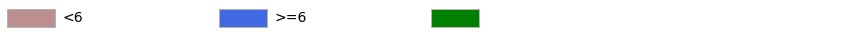

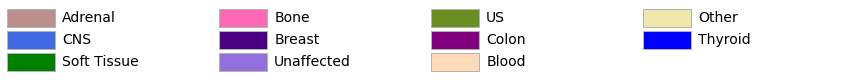

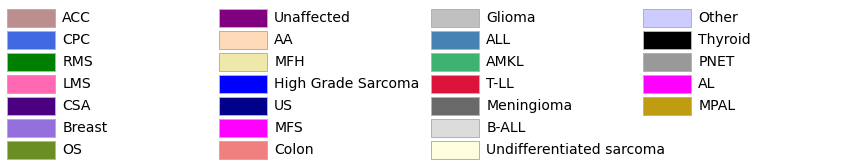

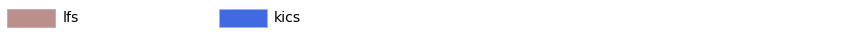

Z Norm


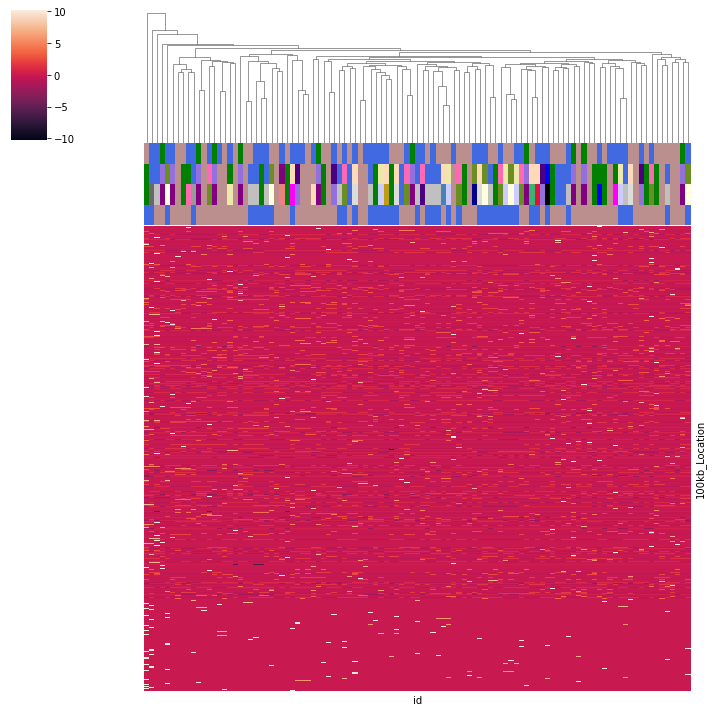

In [15]:
kMatrix = cleanMatrix(createMatrix(kicsWindowFile))
kMatrix1 = umapFormat(kMatrix)
kMatrix1['dataset']='kics'
kMatrix2 = kMatrix1.reset_index()

lMatrix = cleanMatrix(createMatrix(lfsWindowFile))
lMatrix1 = umapFormat(lMatrix)
lMatrix1['dataset']='lfs'
lMatrix2 = lMatrix1.reset_index()

mergeMatrix = pd.concat([kMatrix2,lMatrix2], axis=0, ignore_index=True)
featNames=['ageofonset','tissue_type','cancer_diagnosis','dataset']

dflist = featNames.copy()
dflist.append('id')
dflist.remove('dataset')
uberL = UberbigLDf[dflist]
uberL['dataset']='lfs'
uberK = UberbigKDf[dflist]
uberK['dataset']='kics'
uberDf = pd.concat([uberL, uberK],axis=0,ignore_index=True)
dflist.append('dataset')

#very similar to colorDict, could be merged with colorDict to make one function that works
#used specifically for the heatmap with KiCS and LFS in it
#has the same functionality/end result
def colorDictKICSLFS(df, colName, listId, dataset, colors=colors):
    
    col = colors[0:len(df[colName].unique())]
    dictionaryFeat = dict(zip(df[colName].unique(), col))
    unique = df[colName].unique()

    if colName != 'dataset':
        dictionaryId = df[['id',colName,'dataset']].drop_duplicates()
    else:
        dictionaryId = df[['id',colName]].drop_duplicates()

    dictionaryId = dict(zip(dictionaryId.id, dictionaryId[colName]))
   
    ids = list(dictionaryId)
    
    columns_colours = pd.Series(ids).map(lambda x: dictionaryFeat[dictionaryId[x]])
    columns_colours.index = ids
    plot_colortable(dictionaryFeat)
    plt.show()
    
    return ids, columns_colours


colourList = []
    
for i in featNames:
    columns, columns_colours = colorDictKICSLFS(uberDf, i, mergeMatrix['id'],mergeMatrix['dataset'])
    colourList.append(columns_colours)
    mergeMatrix.index = mergeMatrix['id']
    mergeMatrix = mergeMatrix.drop(list(set(mergeMatrix['id']).symmetric_difference(set(columns))),axis=0)

print('Z Norm')
mergeMatrix = mergeMatrix.fillna(0)
mergeMatrix = mergeMatrix.drop(['id','dataset'],axis=1)
mergeMatrix = mergeMatrix.T

matrixA = zScoreNorm(mergeMatrix)
matrixA = matrixA.dropna(axis=0, how='all')
#print(matrixA.isnull().sum().sum())
sns.clustermap(matrixA, metric="hamming", method='complete',row_cluster = False, col_colors=colourList,
                    yticklabels=False,xticklabels=False)
plt.show()

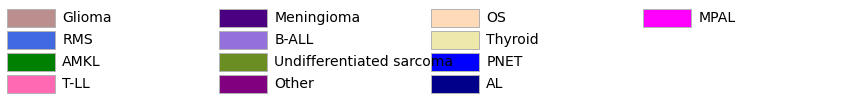

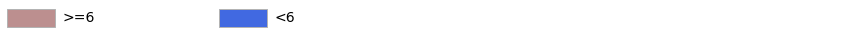

Z Norm


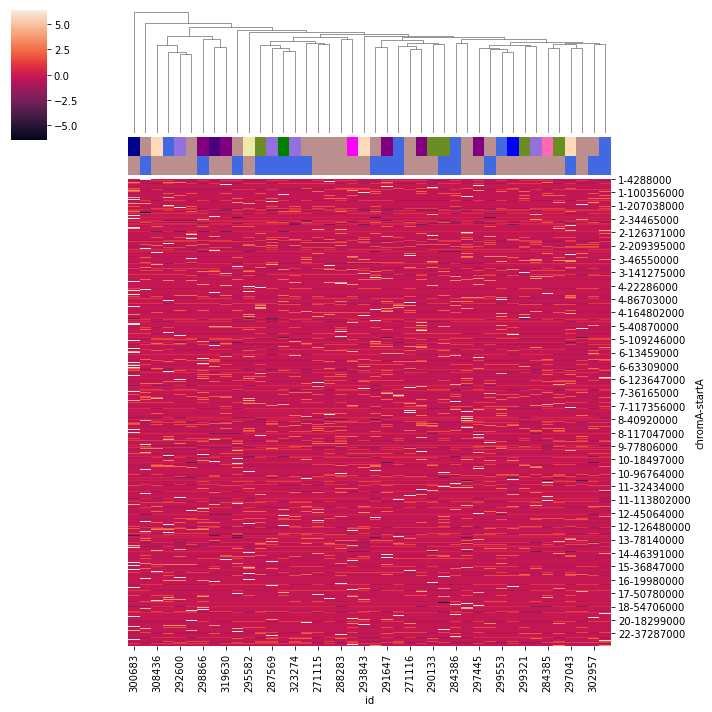

In [16]:
clusterMap(kics_1kb, UberbigKDf, ['cancer_diagnosis','ageofonset'])

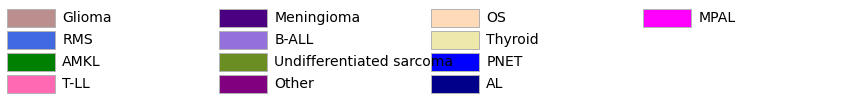

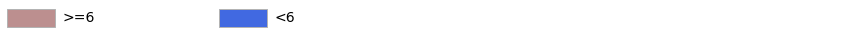

Z Norm


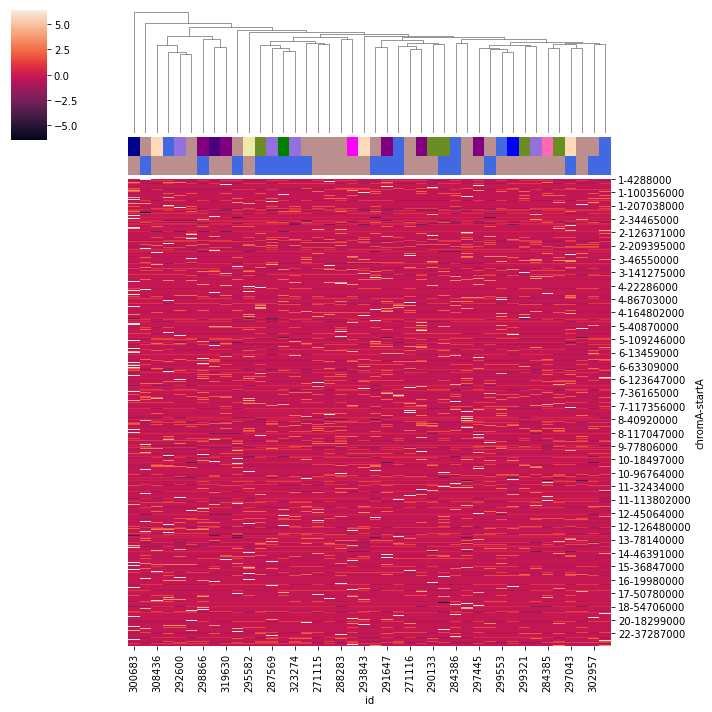

In [17]:
clusterMap(kicsWindowFile, UberbigKDf, ['cancer_diagnosis','ageofonset'])

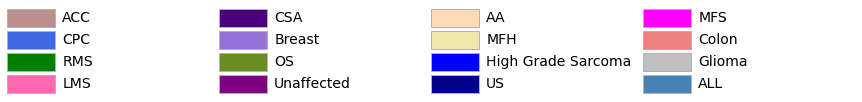

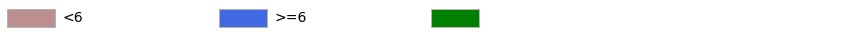

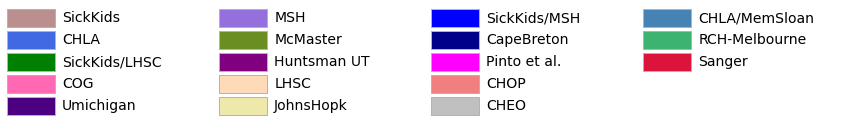

Z Norm


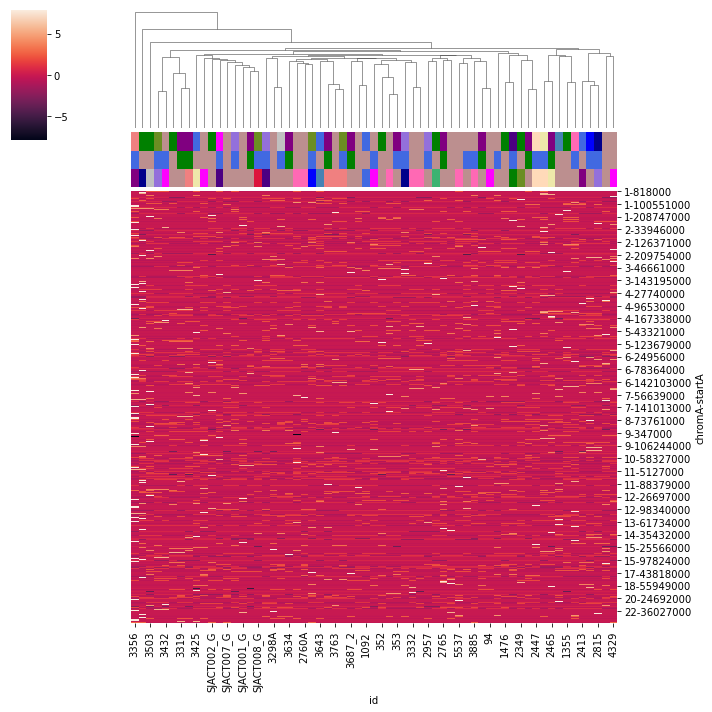

In [18]:
clusterMap(lfsWindowFile, UberbigLDf, ['cancer_diagnosis','ageofonset','Hospital'])
#no name means unaffected!!

# PCA

In [19]:
"""
PCA
"""
from sklearn.decomposition import PCA

In [20]:
"""
PCA Continued
"""
kMatrix = cleanMatrix(createMatrix(kicsWindowFile))
kMatrix1 = umapFormat(kMatrix)
kMatrix1['dataset']='kics'
kMatrix2 = kMatrix1.reset_index()

lMatrix = cleanMatrix(createMatrix(lfsWindowFile))
lMatrix1 = umapFormat(lMatrix)
lMatrix1['dataset']='lfs'
lMatrix2 = lMatrix1.reset_index()

mergeMatrix = pd.concat([kMatrix2,lMatrix2], axis=0, ignore_index=True)
print(mergeMatrix)

100kb_Location          id  1-4288000  1-4532000  1-5934000  1-6814000  \
0                 19_18442          0        0.0          0          0   
1                   245676          0        0.0          0          0   
2                   271113          1        0.0          2          0   
3                   271114          1        0.0          0          0   
4                   271115          0        0.0          0          0   
..                     ...        ...        ...        ...        ...   
138             SJACT001_G          0        NaN          0          0   
139             SJACT002_G          0        NaN          0          0   
140             SJACT005_G          0        NaN          0          0   
141             SJACT007_G          0        NaN          2          0   
142             SJACT008_G          0        NaN          0          1   

100kb_Location  1-6815000  1-7242000  1-8446000  1-8501000  1-8502000  ...  \
0                       0        

In [21]:
mergeMatrix = mergeMatrix.fillna(0)

In [22]:
#features
featList = list(mergeMatrix.columns)
featList.remove('dataset')
featList.remove('id')

listId = mergeMatrix['id']

x = mergeMatrix.loc[:,featList].values

#target
y = mergeMatrix.loc[:,['dataset']].values

#standardizing
x = StandardScaler().fit_transform(x)

# Outliers in PCA

In [23]:
pca = PCA(n_components=2)
pComponents = pca.fit_transform(x)
#PRINT THIS OUT AND FIND THE OUTLIERS
#print(pComponents)

pDf = pd.DataFrame(data = pComponents, columns = ['PC1','PC2'])
bigDf = pd.concat([pDf, mergeMatrix[['dataset']]], axis=1)

outlierDf = pd.concat([bigDf,listId],axis=1)
print(bigDf)
print(outlierDf)

          PC1       PC2 dataset
0   -4.175131 -2.777495    kics
1   -4.226904 -3.429638    kics
2   -4.149832 -2.735860    kics
3   -3.203248 -2.082624    kics
4   -2.752371 -2.520100    kics
..        ...       ...     ...
138 -3.412252 -2.518209     lfs
139 -4.030645 -3.125478     lfs
140 -2.517380 -3.108786     lfs
141 -3.352316 -2.091292     lfs
142 -3.742024 -3.275870     lfs

[143 rows x 3 columns]
          PC1       PC2 dataset          id
0   -4.175131 -2.777495    kics    19_18442
1   -4.226904 -3.429638    kics      245676
2   -4.149832 -2.735860    kics      271113
3   -3.203248 -2.082624    kics      271114
4   -2.752371 -2.520100    kics      271115
..        ...       ...     ...         ...
138 -3.412252 -2.518209     lfs  SJACT001_G
139 -4.030645 -3.125478     lfs  SJACT002_G
140 -2.517380 -3.108786     lfs  SJACT005_G
141 -3.352316 -2.091292     lfs  SJACT007_G
142 -3.742024 -3.275870     lfs  SJACT008_G

[143 rows x 4 columns]


In [24]:
#find outliers
print(outlierDf.loc[outlierDf['PC1'] > 175])
outlier1 = UberbigLDf.loc[UberbigLDf['id'] == '3356'].iloc[0]
print(outlier1[['id','ageofonset','cancer1','tissue_type','Hospital']])

print(outlierDf.loc[outlierDf['PC2'] > 100])

#print out the information of each outlier
outlier2 = UberbigKDf.loc[UberbigKDf['id'] == '274027']
print("no clinical data for id 274027")

group1 = outlierDf.loc[(outlierDf['PC2'] > 25) & (outlierDf['PC1']>25)]
print(group1)

outlier2 = UberbigKDf.loc[UberbigKDf['id'] == '293107']
print("no clincal data for id 293107")

outlier2 = UberbigKDf.loc[UberbigKDf['id'] == '300683'].iloc[0]
print(outlier2[['id','cancer_diagnosis', 'tissue_type','ageofonset']])
#print(list(UberbigKDf.columns))
#print(UberbigKDf['id'].unique())

outlier2 = UberbigKDf.loc[UberbigKDf['id'] == '301002']
print("no clincal data for id 301002")

outlier1 = UberbigLDf.loc[UberbigLDf['id'] == '3365'].iloc[0]
print(outlier1[['id','ageofonset','cancer1','tissue_type','Hospital']]) 

#there is a better way to do this other than manually. Should make a function for it
#something that will search based on the location of the point
#print out all points that meet that criteria
#go through all the points and try to find if it exists and if it does, print out the information in the columns

            PC1        PC2 dataset    id
107  239.238073 -69.588606     lfs  3356
id                                 3356
ageofonset                           <6
cancer1        Choroid plexus carcinoma
tissue_type                         CNS
Hospital                           CHLA
Name: 2024, dtype: object
          PC1         PC2 dataset      id
10  41.757081  142.177201    kics  274027
no clinical data for id 274027
           PC1         PC2 dataset      id
10   41.757081  142.177201    kics  274027
33   34.394825   59.596666    kics  293107
55   32.175406   59.304711    kics  300683
57   37.026090   54.651924    kics  301002
109  36.121196   92.858325     lfs    3365
no clincal data for id 293107
id                  300683
cancer_diagnosis    Glioma
tissue_type            CNS
ageofonset             >=6
Name: 94982, dtype: object
no clincal data for id 301002
id                                 3365
ageofonset                           <6
cancer1        Adrenocortical carcinoma
tiss

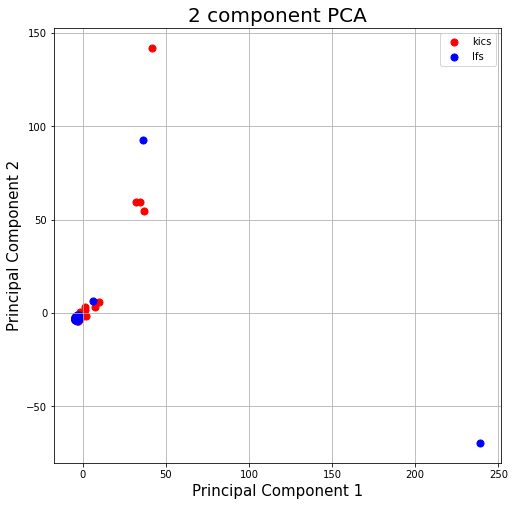

In [25]:
#visualization of PCA
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['kics', 'lfs']
colors = ['r', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = bigDf['dataset'] == target
    ax.scatter(bigDf.loc[indicesToKeep, 'PC1']
               , bigDf.loc[indicesToKeep, 'PC2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

# UMAP

In [26]:
"""
UMAP of only one kics or lfs, not the two together
"""
from umap import UMAP

matrix = cleanMatrix(createMatrix(lfsWindowFile))

df = matrix.reset_index()
df['100kb_Location'] = df['chromA'].astype(str)+"-"+df['startA'].astype(str)
df.index = df['100kb_Location']
df1 = df.drop(['chromA','startA','100kb_Location'],axis=1)
df1 = df1.T

idList = df1.index
cancerList = []
dropList = []

print(len(idList))

for i in idList:
    test = UberbigLDf.loc[UberbigLDf['id']==i,'ageofonset']
    
    if test.empty:
        #drop the id that can't be found
        cancerList.append('Other')
    else:
        #add the id found's cancer diagnosis
        cancerList.append(test.iloc[0]) 



63


In [27]:
df1 = df1.drop(dropList)

In [28]:
df1['ageofonset'] = cancerList

colList = list(df1.columns)
colList.remove('ageofonset')
window_data = df1[colList].values

In [29]:
# import umap
# from umap import UMAP

# reducer = umap.UMAP(n_neighbors = 3, min_dist = 0.5, n_components = 2, verbose = True)

# scaled_window_data = StandardScaler().fit_transform(window_data)
# embedding = reducer.fit_transform(window_data)
# embedding.shape

Index(['id', '1-4288000', '1-4532000', '1-5934000', '1-6814000', '1-6815000',
       '1-7242000', '1-8446000', '1-8501000', '1-8502000',
       ...
       'X-130231000', 'X-134776000', 'X-134777000', 'X-141583000',
       'X-147146000', 'X-149557000', 'X-152867000', 'X-152883000',
       'X-154909000', 'X-155196000'],
      dtype='object', name='100kb_Location', length=10996)
2 0.0 euclidean
UMAP(min_dist=0.0, n_neighbors=2, verbose=True)
Wed Dec 21 09:36:40 2022 Construct fuzzy simplicial set
Wed Dec 21 09:36:40 2022 Finding Nearest Neighbors
Wed Dec 21 09:36:41 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:36:42 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:36:43 2022 Finished embedding


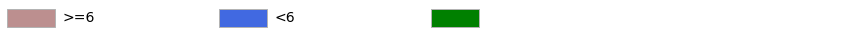

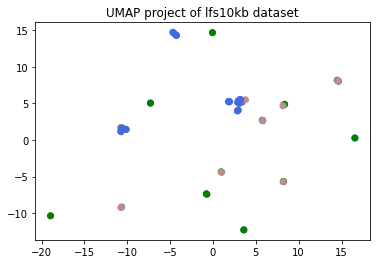

2 0.0 manhattan
UMAP(metric='manhattan', min_dist=0.0, n_neighbors=2, verbose=True)
Wed Dec 21 09:36:43 2022 Construct fuzzy simplicial set
Wed Dec 21 09:36:43 2022 Finding Nearest Neighbors
Wed Dec 21 09:36:43 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:36:43 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:36:44 2022 Finished embedding


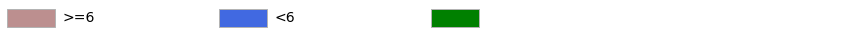

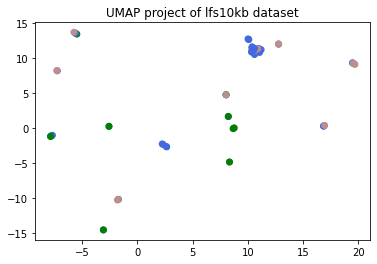

2 0.0 chebyshev
UMAP(metric='chebyshev', min_dist=0.0, n_neighbors=2, verbose=True)
Wed Dec 21 09:36:44 2022 Construct fuzzy simplicial set
Wed Dec 21 09:36:44 2022 Finding Nearest Neighbors
Wed Dec 21 09:36:44 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:36:44 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:36:45 2022 Finished embedding


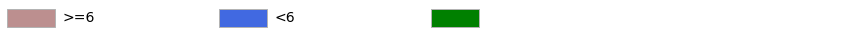

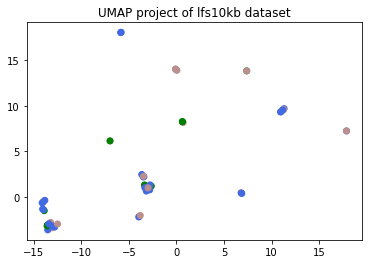

2 0.0 jaccard
UMAP(angular_rp_forest=True, metric='jaccard', min_dist=0.0, n_neighbors=2, verbose=True)
Wed Dec 21 09:36:45 2022 Construct fuzzy simplicial set
Wed Dec 21 09:36:45 2022 Finding Nearest Neighbors
Wed Dec 21 09:36:45 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:36:45 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:36:46 2022 Finished embedding


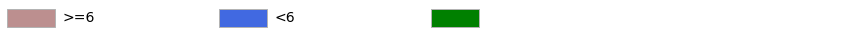

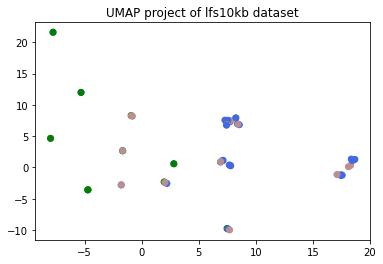

2 0.1 euclidean
UMAP(n_neighbors=2, verbose=True)
Wed Dec 21 09:36:47 2022 Construct fuzzy simplicial set
Wed Dec 21 09:36:47 2022 Finding Nearest Neighbors
Wed Dec 21 09:36:47 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:36:47 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:36:48 2022 Finished embedding


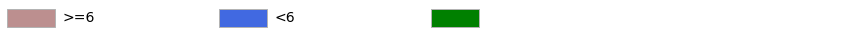

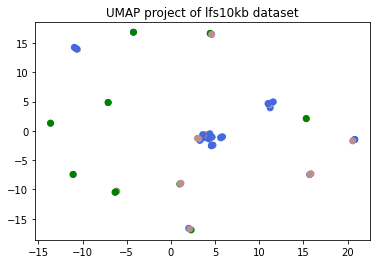

2 0.1 manhattan
UMAP(metric='manhattan', n_neighbors=2, verbose=True)
Wed Dec 21 09:36:48 2022 Construct fuzzy simplicial set
Wed Dec 21 09:36:48 2022 Finding Nearest Neighbors
Wed Dec 21 09:36:48 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:36:48 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:36:49 2022 Finished embedding


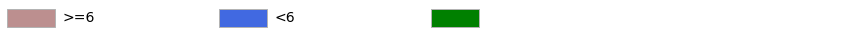

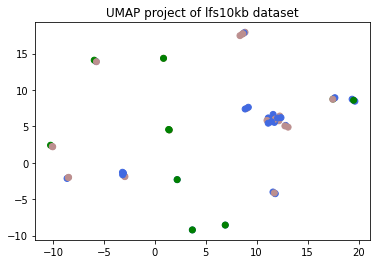

2 0.1 chebyshev
UMAP(metric='chebyshev', n_neighbors=2, verbose=True)
Wed Dec 21 09:36:49 2022 Construct fuzzy simplicial set
Wed Dec 21 09:36:49 2022 Finding Nearest Neighbors
Wed Dec 21 09:36:49 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:36:49 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:36:50 2022 Finished embedding


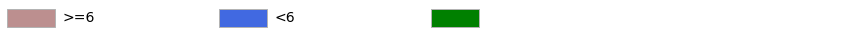

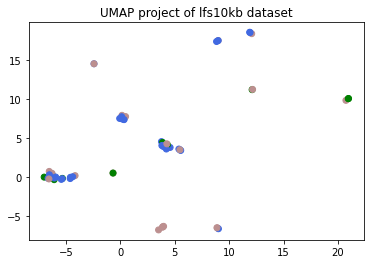

2 0.1 jaccard
UMAP(angular_rp_forest=True, metric='jaccard', n_neighbors=2, verbose=True)
Wed Dec 21 09:36:50 2022 Construct fuzzy simplicial set
Wed Dec 21 09:36:50 2022 Finding Nearest Neighbors
Wed Dec 21 09:36:50 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:36:50 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:36:51 2022 Finished embedding


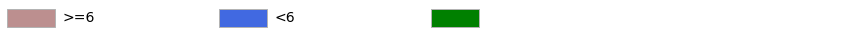

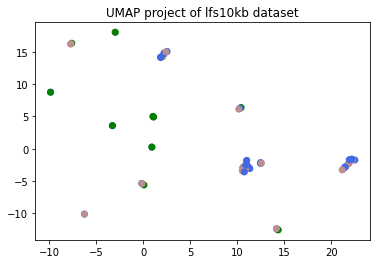

2 0.25 euclidean
UMAP(min_dist=0.25, n_neighbors=2, verbose=True)
Wed Dec 21 09:36:51 2022 Construct fuzzy simplicial set
Wed Dec 21 09:36:51 2022 Finding Nearest Neighbors
Wed Dec 21 09:36:51 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:36:51 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:36:52 2022 Finished embedding


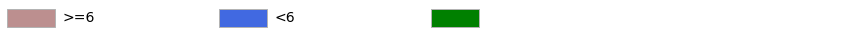

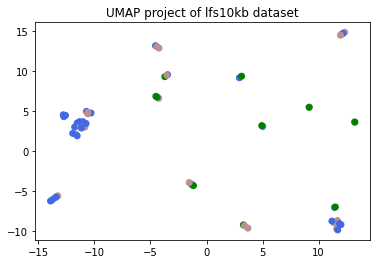

2 0.25 manhattan
UMAP(metric='manhattan', min_dist=0.25, n_neighbors=2, verbose=True)
Wed Dec 21 09:36:52 2022 Construct fuzzy simplicial set
Wed Dec 21 09:36:52 2022 Finding Nearest Neighbors
Wed Dec 21 09:36:52 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:36:52 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:36:53 2022 Finished embedding


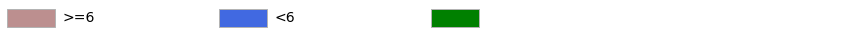

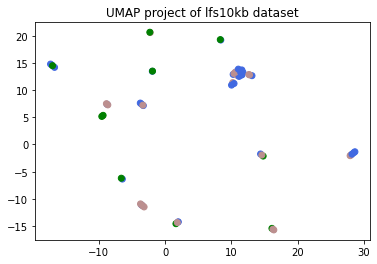

2 0.25 chebyshev
UMAP(metric='chebyshev', min_dist=0.25, n_neighbors=2, verbose=True)
Wed Dec 21 09:36:53 2022 Construct fuzzy simplicial set
Wed Dec 21 09:36:53 2022 Finding Nearest Neighbors
Wed Dec 21 09:36:53 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:36:53 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:36:54 2022 Finished embedding


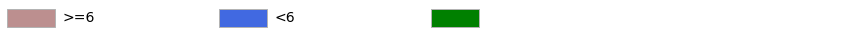

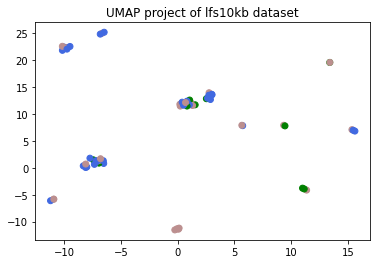

2 0.25 jaccard
UMAP(angular_rp_forest=True, metric='jaccard', min_dist=0.25, n_neighbors=2, verbose=True)
Wed Dec 21 09:36:54 2022 Construct fuzzy simplicial set
Wed Dec 21 09:36:54 2022 Finding Nearest Neighbors
Wed Dec 21 09:36:54 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:36:54 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:36:55 2022 Finished embedding


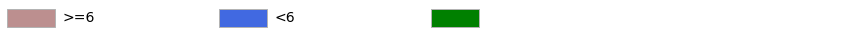

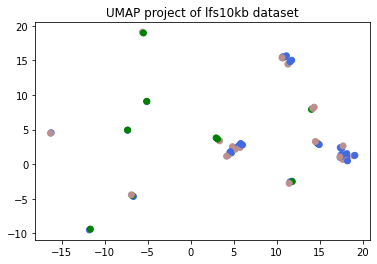

2 0.5 euclidean
UMAP(min_dist=0.5, n_neighbors=2, verbose=True)
Wed Dec 21 09:36:55 2022 Construct fuzzy simplicial set
Wed Dec 21 09:36:55 2022 Finding Nearest Neighbors
Wed Dec 21 09:36:55 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:36:55 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:36:56 2022 Finished embedding


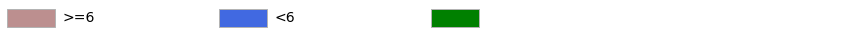

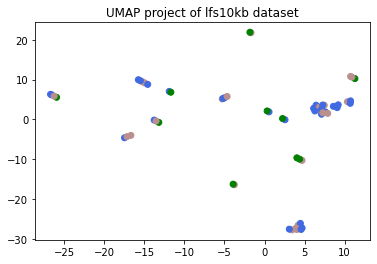

2 0.5 manhattan
UMAP(metric='manhattan', min_dist=0.5, n_neighbors=2, verbose=True)
Wed Dec 21 09:36:56 2022 Construct fuzzy simplicial set
Wed Dec 21 09:36:57 2022 Finding Nearest Neighbors
Wed Dec 21 09:36:57 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:36:57 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:36:58 2022 Finished embedding


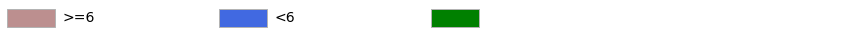

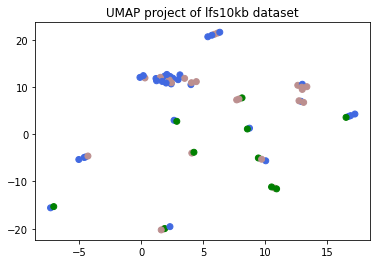

2 0.5 chebyshev
UMAP(metric='chebyshev', min_dist=0.5, n_neighbors=2, verbose=True)
Wed Dec 21 09:36:58 2022 Construct fuzzy simplicial set
Wed Dec 21 09:36:58 2022 Finding Nearest Neighbors
Wed Dec 21 09:36:58 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:36:58 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:36:59 2022 Finished embedding


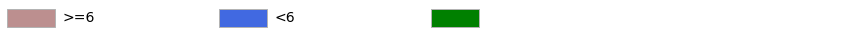

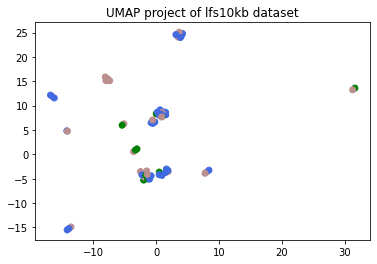

2 0.5 jaccard
UMAP(angular_rp_forest=True, metric='jaccard', min_dist=0.5, n_neighbors=2, verbose=True)
Wed Dec 21 09:36:59 2022 Construct fuzzy simplicial set
Wed Dec 21 09:36:59 2022 Finding Nearest Neighbors
Wed Dec 21 09:36:59 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:36:59 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:37:00 2022 Finished embedding


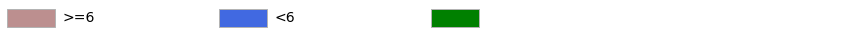

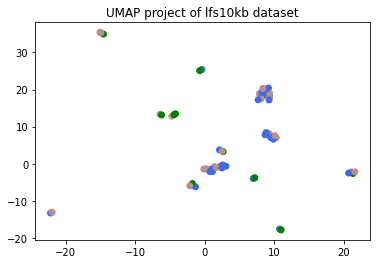

2 0.8 euclidean
UMAP(min_dist=0.8, n_neighbors=2, verbose=True)
Wed Dec 21 09:37:00 2022 Construct fuzzy simplicial set
Wed Dec 21 09:37:00 2022 Finding Nearest Neighbors
Wed Dec 21 09:37:00 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:37:00 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:37:01 2022 Finished embedding


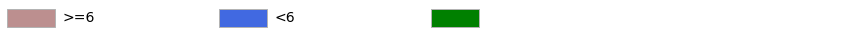

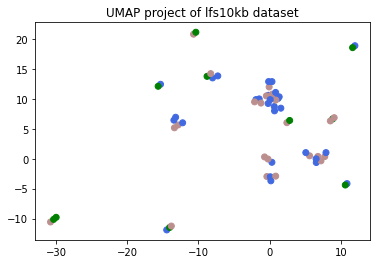

2 0.8 manhattan
UMAP(metric='manhattan', min_dist=0.8, n_neighbors=2, verbose=True)
Wed Dec 21 09:37:01 2022 Construct fuzzy simplicial set
Wed Dec 21 09:37:01 2022 Finding Nearest Neighbors
Wed Dec 21 09:37:01 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:37:01 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:37:02 2022 Finished embedding


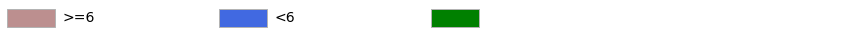

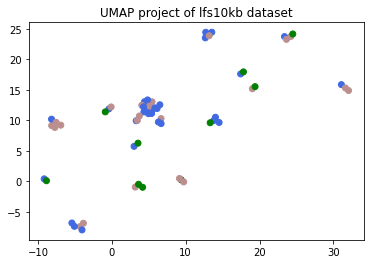

2 0.8 chebyshev
UMAP(metric='chebyshev', min_dist=0.8, n_neighbors=2, verbose=True)
Wed Dec 21 09:37:02 2022 Construct fuzzy simplicial set
Wed Dec 21 09:37:02 2022 Finding Nearest Neighbors
Wed Dec 21 09:37:02 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:37:02 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:37:03 2022 Finished embedding


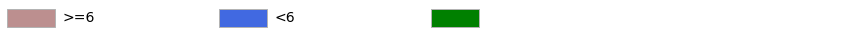

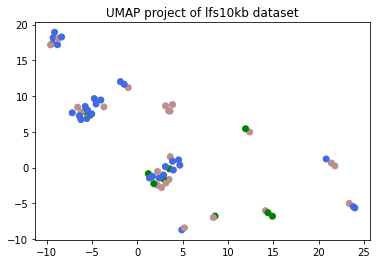

2 0.8 jaccard
UMAP(angular_rp_forest=True, metric='jaccard', min_dist=0.8, n_neighbors=2, verbose=True)
Wed Dec 21 09:37:03 2022 Construct fuzzy simplicial set
Wed Dec 21 09:37:03 2022 Finding Nearest Neighbors
Wed Dec 21 09:37:03 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:37:03 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:37:04 2022 Finished embedding


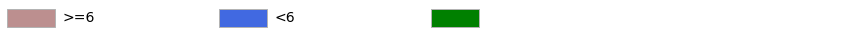

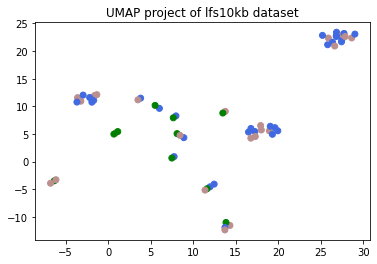

2 0.99 euclidean
UMAP(min_dist=0.99, n_neighbors=2, verbose=True)
Wed Dec 21 09:37:04 2022 Construct fuzzy simplicial set
Wed Dec 21 09:37:04 2022 Finding Nearest Neighbors
Wed Dec 21 09:37:04 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:37:04 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:37:05 2022 Finished embedding


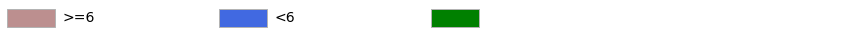

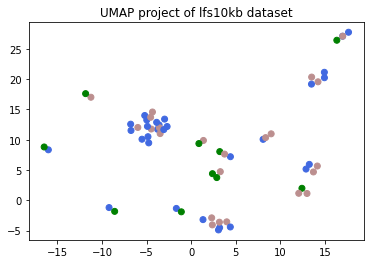

2 0.99 manhattan
UMAP(metric='manhattan', min_dist=0.99, n_neighbors=2, verbose=True)
Wed Dec 21 09:37:05 2022 Construct fuzzy simplicial set
Wed Dec 21 09:37:05 2022 Finding Nearest Neighbors
Wed Dec 21 09:37:05 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:37:05 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:37:06 2022 Finished embedding


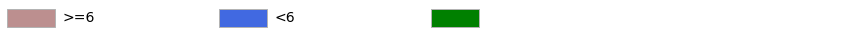

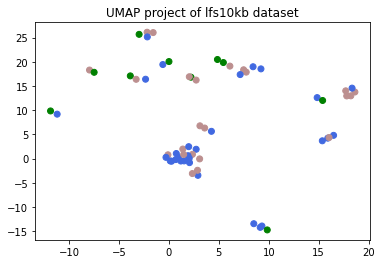

2 0.99 chebyshev
UMAP(metric='chebyshev', min_dist=0.99, n_neighbors=2, verbose=True)
Wed Dec 21 09:37:07 2022 Construct fuzzy simplicial set
Wed Dec 21 09:37:07 2022 Finding Nearest Neighbors
Wed Dec 21 09:37:07 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:37:07 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:37:08 2022 Finished embedding


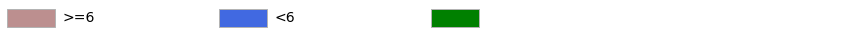

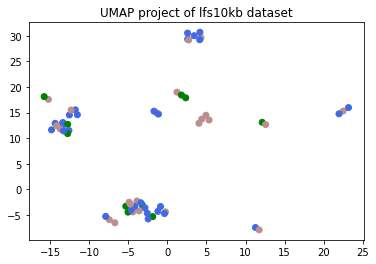

2 0.99 jaccard
UMAP(angular_rp_forest=True, metric='jaccard', min_dist=0.99, n_neighbors=2, verbose=True)
Wed Dec 21 09:37:08 2022 Construct fuzzy simplicial set
Wed Dec 21 09:37:08 2022 Finding Nearest Neighbors
Wed Dec 21 09:37:08 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:37:08 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:37:09 2022 Finished embedding


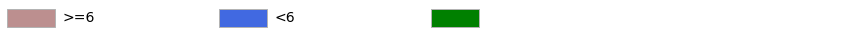

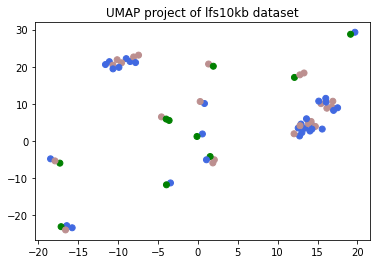

5 0.0 euclidean
UMAP(min_dist=0.0, n_neighbors=5, verbose=True)
Wed Dec 21 09:37:09 2022 Construct fuzzy simplicial set
Wed Dec 21 09:37:09 2022 Finding Nearest Neighbors
Wed Dec 21 09:37:09 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:37:09 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:37:10 2022 Finished embedding


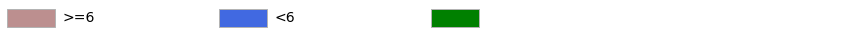

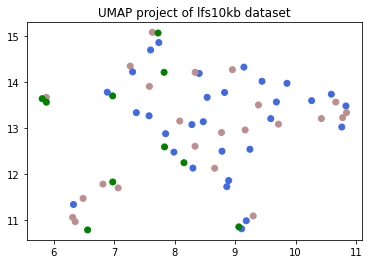

5 0.0 manhattan
UMAP(metric='manhattan', min_dist=0.0, n_neighbors=5, verbose=True)
Wed Dec 21 09:37:10 2022 Construct fuzzy simplicial set
Wed Dec 21 09:37:10 2022 Finding Nearest Neighbors
Wed Dec 21 09:37:10 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:37:10 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:37:11 2022 Finished embedding


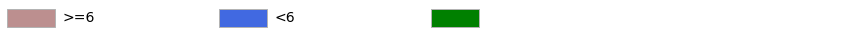

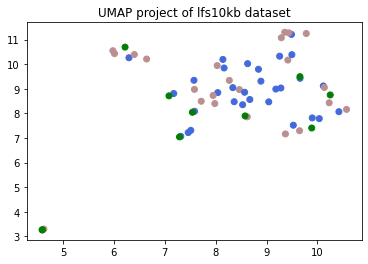

5 0.0 chebyshev
UMAP(metric='chebyshev', min_dist=0.0, n_neighbors=5, verbose=True)
Wed Dec 21 09:37:11 2022 Construct fuzzy simplicial set
Wed Dec 21 09:37:11 2022 Finding Nearest Neighbors
Wed Dec 21 09:37:11 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:37:11 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:37:12 2022 Finished embedding


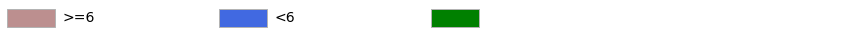

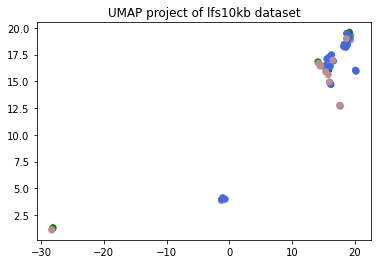

5 0.0 jaccard
UMAP(angular_rp_forest=True, metric='jaccard', min_dist=0.0, n_neighbors=5, verbose=True)
Wed Dec 21 09:37:12 2022 Construct fuzzy simplicial set
Wed Dec 21 09:37:12 2022 Finding Nearest Neighbors
Wed Dec 21 09:37:12 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:37:12 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:37:13 2022 Finished embedding


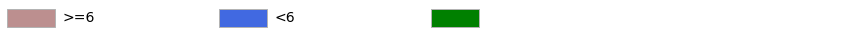

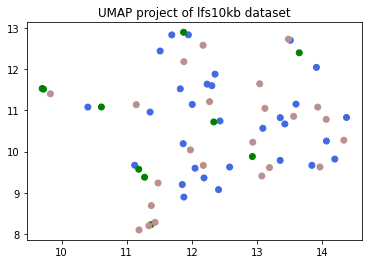

5 0.1 euclidean
UMAP(n_neighbors=5, verbose=True)
Wed Dec 21 09:37:13 2022 Construct fuzzy simplicial set
Wed Dec 21 09:37:13 2022 Finding Nearest Neighbors
Wed Dec 21 09:37:13 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:37:13 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:37:14 2022 Finished embedding


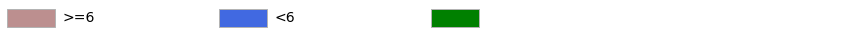

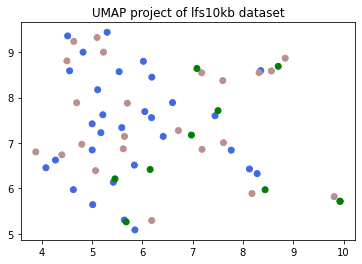

5 0.1 manhattan
UMAP(metric='manhattan', n_neighbors=5, verbose=True)
Wed Dec 21 09:37:14 2022 Construct fuzzy simplicial set
Wed Dec 21 09:37:14 2022 Finding Nearest Neighbors
Wed Dec 21 09:37:14 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:37:14 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:37:16 2022 Finished embedding


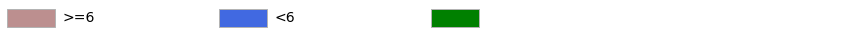

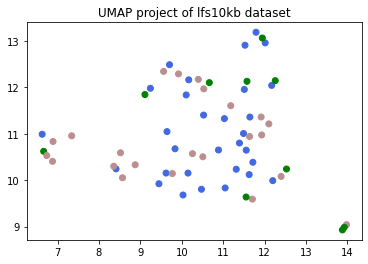

5 0.1 chebyshev
UMAP(metric='chebyshev', n_neighbors=5, verbose=True)
Wed Dec 21 09:37:16 2022 Construct fuzzy simplicial set
Wed Dec 21 09:37:16 2022 Finding Nearest Neighbors
Wed Dec 21 09:37:16 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:37:16 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:37:17 2022 Finished embedding


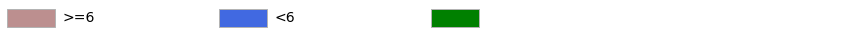

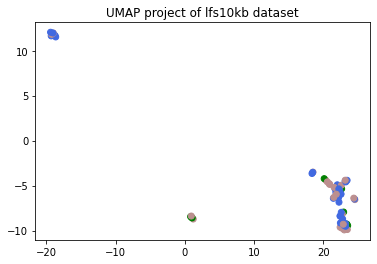

5 0.1 jaccard
UMAP(angular_rp_forest=True, metric='jaccard', n_neighbors=5, verbose=True)
Wed Dec 21 09:37:17 2022 Construct fuzzy simplicial set
Wed Dec 21 09:37:17 2022 Finding Nearest Neighbors
Wed Dec 21 09:37:17 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:37:17 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:37:18 2022 Finished embedding


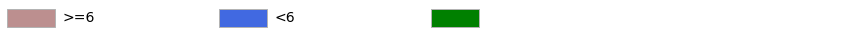

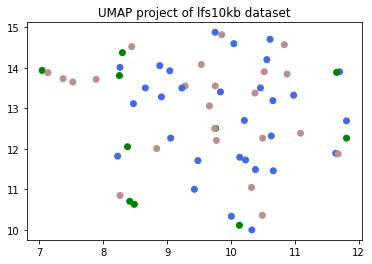

5 0.25 euclidean
UMAP(min_dist=0.25, n_neighbors=5, verbose=True)
Wed Dec 21 09:37:18 2022 Construct fuzzy simplicial set
Wed Dec 21 09:37:18 2022 Finding Nearest Neighbors
Wed Dec 21 09:37:18 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:37:18 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:37:19 2022 Finished embedding


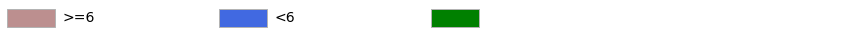

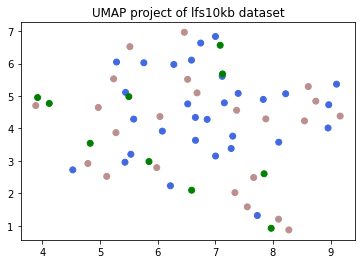

5 0.25 manhattan
UMAP(metric='manhattan', min_dist=0.25, n_neighbors=5, verbose=True)
Wed Dec 21 09:37:19 2022 Construct fuzzy simplicial set
Wed Dec 21 09:37:19 2022 Finding Nearest Neighbors
Wed Dec 21 09:37:19 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:37:19 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:37:20 2022 Finished embedding


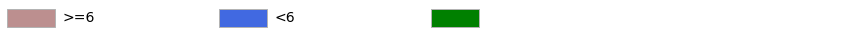

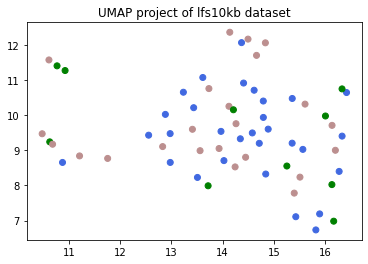

5 0.25 chebyshev
UMAP(metric='chebyshev', min_dist=0.25, n_neighbors=5, verbose=True)
Wed Dec 21 09:37:20 2022 Construct fuzzy simplicial set
Wed Dec 21 09:37:20 2022 Finding Nearest Neighbors
Wed Dec 21 09:37:20 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:37:20 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:37:21 2022 Finished embedding


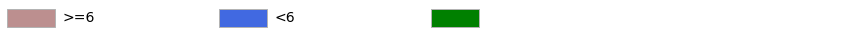

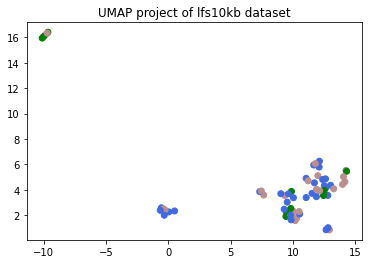

5 0.25 jaccard
UMAP(angular_rp_forest=True, metric='jaccard', min_dist=0.25, n_neighbors=5, verbose=True)
Wed Dec 21 09:37:21 2022 Construct fuzzy simplicial set
Wed Dec 21 09:37:21 2022 Finding Nearest Neighbors
Wed Dec 21 09:37:21 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:37:21 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:37:22 2022 Finished embedding


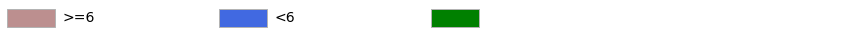

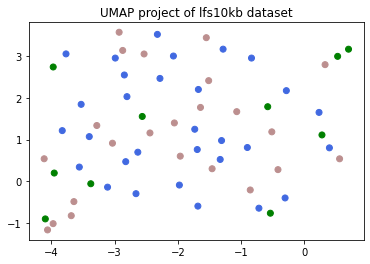

5 0.5 euclidean
UMAP(min_dist=0.5, n_neighbors=5, verbose=True)
Wed Dec 21 09:37:22 2022 Construct fuzzy simplicial set
Wed Dec 21 09:37:22 2022 Finding Nearest Neighbors
Wed Dec 21 09:37:22 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:37:22 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:37:24 2022 Finished embedding


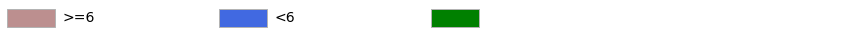

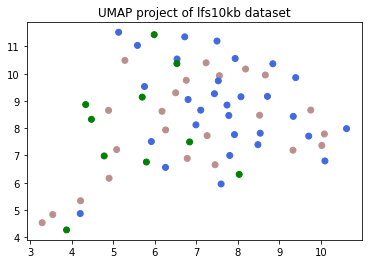

5 0.5 manhattan
UMAP(metric='manhattan', min_dist=0.5, n_neighbors=5, verbose=True)
Wed Dec 21 09:37:24 2022 Construct fuzzy simplicial set
Wed Dec 21 09:37:24 2022 Finding Nearest Neighbors
Wed Dec 21 09:37:24 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:37:24 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:37:25 2022 Finished embedding


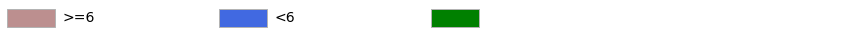

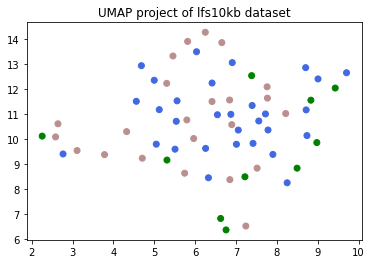

5 0.5 chebyshev
UMAP(metric='chebyshev', min_dist=0.5, n_neighbors=5, verbose=True)
Wed Dec 21 09:37:25 2022 Construct fuzzy simplicial set
Wed Dec 21 09:37:25 2022 Finding Nearest Neighbors
Wed Dec 21 09:37:25 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:37:25 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:37:26 2022 Finished embedding


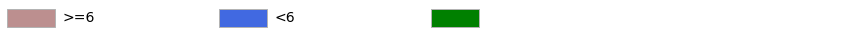

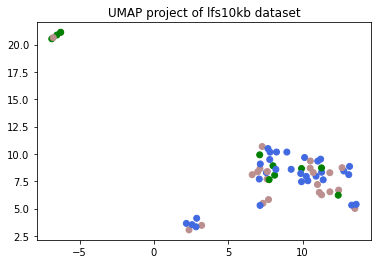

5 0.5 jaccard
UMAP(angular_rp_forest=True, metric='jaccard', min_dist=0.5, n_neighbors=5, verbose=True)
Wed Dec 21 09:37:26 2022 Construct fuzzy simplicial set
Wed Dec 21 09:37:26 2022 Finding Nearest Neighbors
Wed Dec 21 09:37:26 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:37:26 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:37:27 2022 Finished embedding


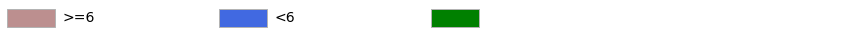

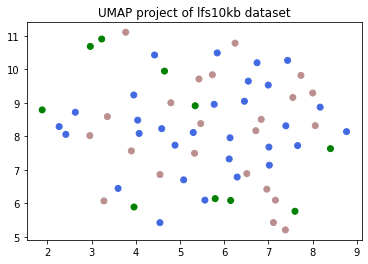

5 0.8 euclidean
UMAP(min_dist=0.8, n_neighbors=5, verbose=True)
Wed Dec 21 09:37:27 2022 Construct fuzzy simplicial set
Wed Dec 21 09:37:27 2022 Finding Nearest Neighbors
Wed Dec 21 09:37:27 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:37:27 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:37:28 2022 Finished embedding


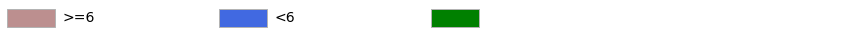

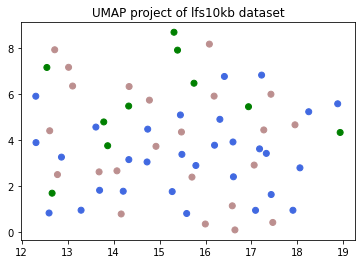

5 0.8 manhattan
UMAP(metric='manhattan', min_dist=0.8, n_neighbors=5, verbose=True)
Wed Dec 21 09:37:28 2022 Construct fuzzy simplicial set
Wed Dec 21 09:37:28 2022 Finding Nearest Neighbors
Wed Dec 21 09:37:28 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:37:28 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:37:29 2022 Finished embedding


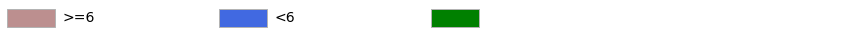

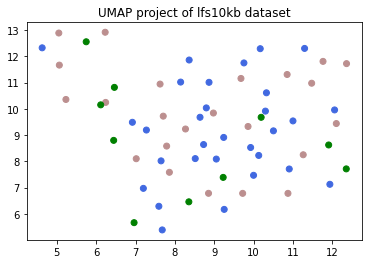

5 0.8 chebyshev
UMAP(metric='chebyshev', min_dist=0.8, n_neighbors=5, verbose=True)
Wed Dec 21 09:37:29 2022 Construct fuzzy simplicial set
Wed Dec 21 09:37:30 2022 Finding Nearest Neighbors
Wed Dec 21 09:37:30 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:37:30 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:37:30 2022 Finished embedding


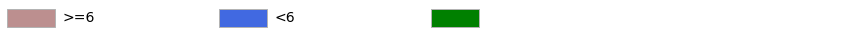

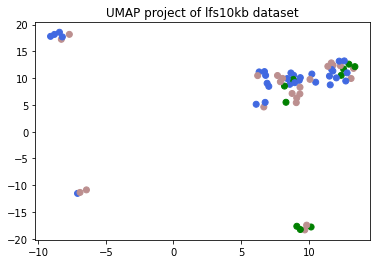

5 0.8 jaccard
UMAP(angular_rp_forest=True, metric='jaccard', min_dist=0.8, n_neighbors=5, verbose=True)
Wed Dec 21 09:37:31 2022 Construct fuzzy simplicial set
Wed Dec 21 09:37:31 2022 Finding Nearest Neighbors
Wed Dec 21 09:37:31 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:37:31 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:37:32 2022 Finished embedding


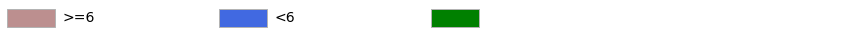

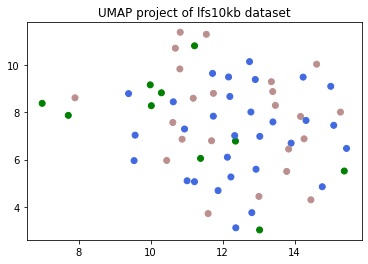

5 0.99 euclidean
UMAP(min_dist=0.99, n_neighbors=5, verbose=True)
Wed Dec 21 09:37:32 2022 Construct fuzzy simplicial set
Wed Dec 21 09:37:32 2022 Finding Nearest Neighbors
Wed Dec 21 09:37:32 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:37:32 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:37:33 2022 Finished embedding


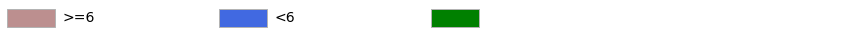

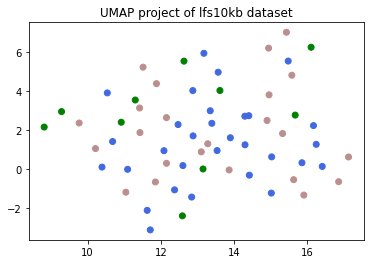

5 0.99 manhattan
UMAP(metric='manhattan', min_dist=0.99, n_neighbors=5, verbose=True)
Wed Dec 21 09:37:34 2022 Construct fuzzy simplicial set
Wed Dec 21 09:37:34 2022 Finding Nearest Neighbors
Wed Dec 21 09:37:34 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:37:34 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:37:35 2022 Finished embedding


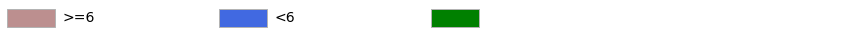

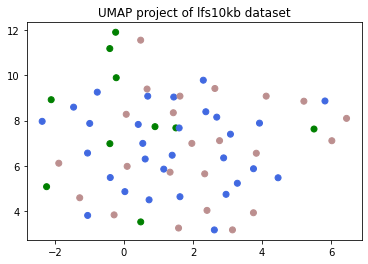

5 0.99 chebyshev
UMAP(metric='chebyshev', min_dist=0.99, n_neighbors=5, verbose=True)
Wed Dec 21 09:37:35 2022 Construct fuzzy simplicial set
Wed Dec 21 09:37:35 2022 Finding Nearest Neighbors
Wed Dec 21 09:37:35 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:37:35 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:37:36 2022 Finished embedding


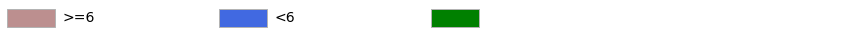

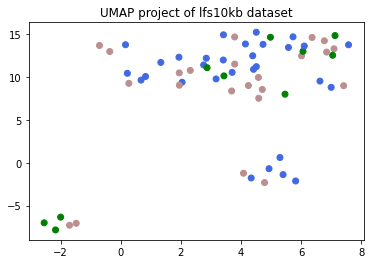

5 0.99 jaccard
UMAP(angular_rp_forest=True, metric='jaccard', min_dist=0.99, n_neighbors=5, verbose=True)
Wed Dec 21 09:37:36 2022 Construct fuzzy simplicial set
Wed Dec 21 09:37:36 2022 Finding Nearest Neighbors
Wed Dec 21 09:37:36 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:37:36 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:37:37 2022 Finished embedding


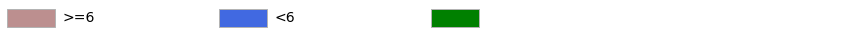

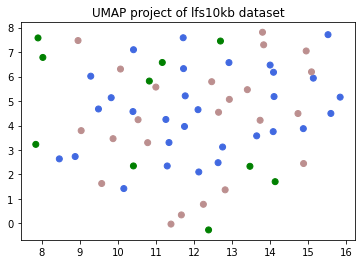

10 0.0 euclidean
UMAP(min_dist=0.0, n_neighbors=10, verbose=True)
Wed Dec 21 09:37:37 2022 Construct fuzzy simplicial set
Wed Dec 21 09:37:37 2022 Finding Nearest Neighbors
Wed Dec 21 09:37:37 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:37:37 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:37:38 2022 Finished embedding


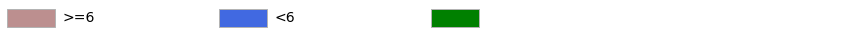

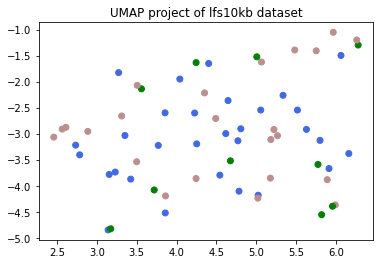

10 0.0 manhattan
UMAP(metric='manhattan', min_dist=0.0, n_neighbors=10, verbose=True)
Wed Dec 21 09:37:38 2022 Construct fuzzy simplicial set
Wed Dec 21 09:37:38 2022 Finding Nearest Neighbors
Wed Dec 21 09:37:38 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:37:38 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:37:39 2022 Finished embedding


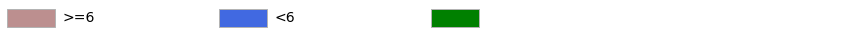

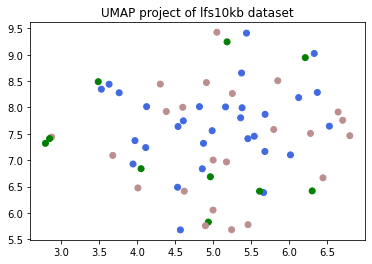

10 0.0 chebyshev
UMAP(metric='chebyshev', min_dist=0.0, n_neighbors=10, verbose=True)
Wed Dec 21 09:37:39 2022 Construct fuzzy simplicial set
Wed Dec 21 09:37:39 2022 Finding Nearest Neighbors
Wed Dec 21 09:37:39 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:37:39 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:37:40 2022 Finished embedding


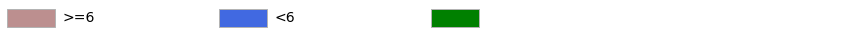

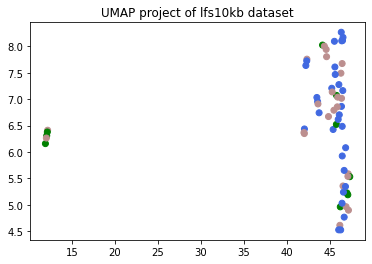

10 0.0 jaccard
UMAP(angular_rp_forest=True, metric='jaccard', min_dist=0.0, n_neighbors=10, verbose=True)
Wed Dec 21 09:37:40 2022 Construct fuzzy simplicial set
Wed Dec 21 09:37:40 2022 Finding Nearest Neighbors
Wed Dec 21 09:37:40 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:37:40 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:37:41 2022 Finished embedding


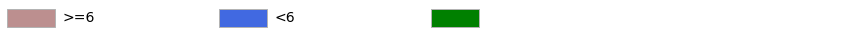

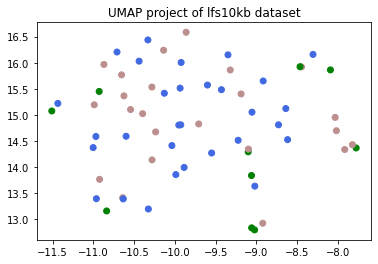

10 0.1 euclidean
UMAP(n_neighbors=10, verbose=True)
Wed Dec 21 09:37:42 2022 Construct fuzzy simplicial set
Wed Dec 21 09:37:42 2022 Finding Nearest Neighbors
Wed Dec 21 09:37:42 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:37:42 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:37:43 2022 Finished embedding


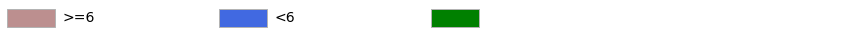

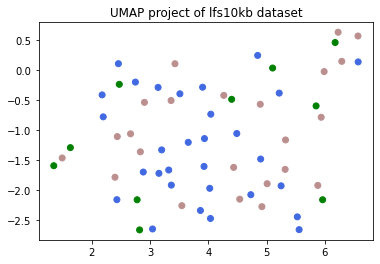

10 0.1 manhattan
UMAP(metric='manhattan', n_neighbors=10, verbose=True)
Wed Dec 21 09:37:43 2022 Construct fuzzy simplicial set
Wed Dec 21 09:37:43 2022 Finding Nearest Neighbors
Wed Dec 21 09:37:43 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:37:43 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:37:44 2022 Finished embedding


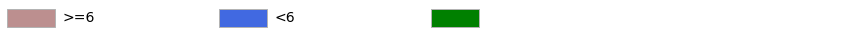

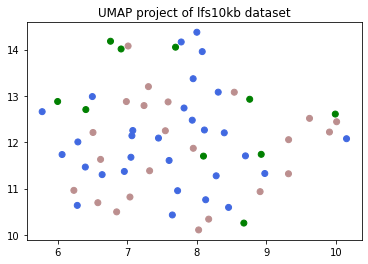

10 0.1 chebyshev
UMAP(metric='chebyshev', n_neighbors=10, verbose=True)
Wed Dec 21 09:37:44 2022 Construct fuzzy simplicial set
Wed Dec 21 09:37:44 2022 Finding Nearest Neighbors
Wed Dec 21 09:37:44 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:37:44 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:37:45 2022 Finished embedding


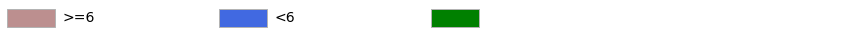

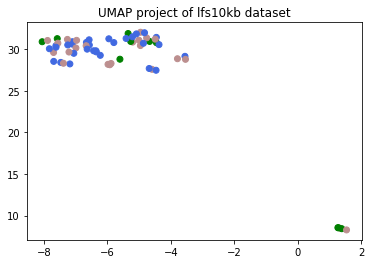

10 0.1 jaccard
UMAP(angular_rp_forest=True, metric='jaccard', n_neighbors=10, verbose=True)
Wed Dec 21 09:37:45 2022 Construct fuzzy simplicial set
Wed Dec 21 09:37:45 2022 Finding Nearest Neighbors
Wed Dec 21 09:37:45 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:37:45 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:37:46 2022 Finished embedding


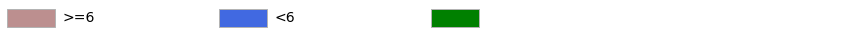

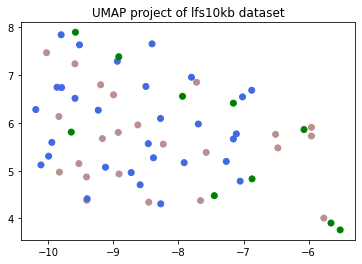

10 0.25 euclidean
UMAP(min_dist=0.25, n_neighbors=10, verbose=True)
Wed Dec 21 09:37:46 2022 Construct fuzzy simplicial set
Wed Dec 21 09:37:46 2022 Finding Nearest Neighbors
Wed Dec 21 09:37:46 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:37:46 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:37:47 2022 Finished embedding


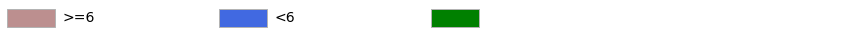

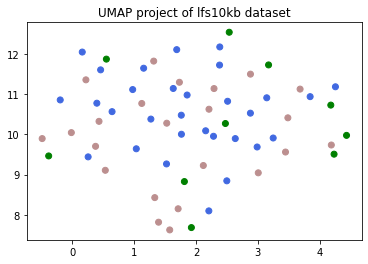

10 0.25 manhattan
UMAP(metric='manhattan', min_dist=0.25, n_neighbors=10, verbose=True)
Wed Dec 21 09:37:47 2022 Construct fuzzy simplicial set
Wed Dec 21 09:37:47 2022 Finding Nearest Neighbors
Wed Dec 21 09:37:47 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:37:47 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:37:48 2022 Finished embedding


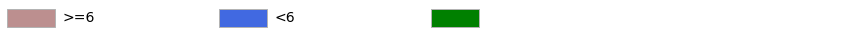

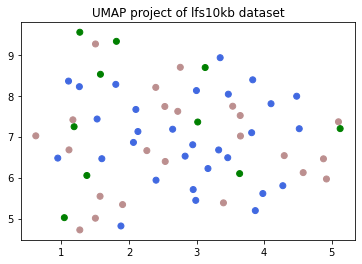

10 0.25 chebyshev
UMAP(metric='chebyshev', min_dist=0.25, n_neighbors=10, verbose=True)
Wed Dec 21 09:37:48 2022 Construct fuzzy simplicial set
Wed Dec 21 09:37:48 2022 Finding Nearest Neighbors
Wed Dec 21 09:37:48 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:37:48 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:37:49 2022 Finished embedding


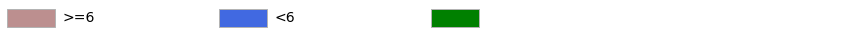

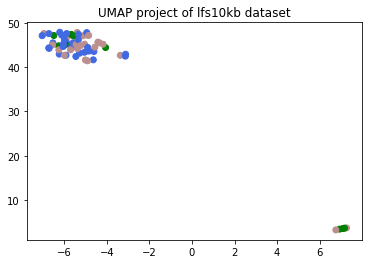

10 0.25 jaccard
UMAP(angular_rp_forest=True, metric='jaccard', min_dist=0.25, n_neighbors=10, verbose=True)
Wed Dec 21 09:37:50 2022 Construct fuzzy simplicial set
Wed Dec 21 09:37:50 2022 Finding Nearest Neighbors
Wed Dec 21 09:37:50 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:37:50 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:37:51 2022 Finished embedding


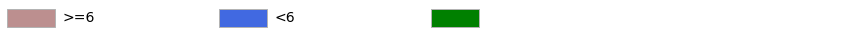

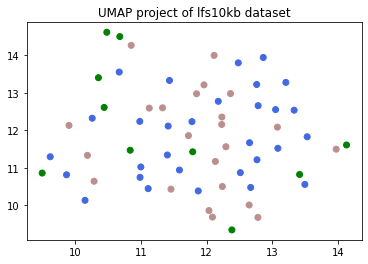

10 0.5 euclidean
UMAP(min_dist=0.5, n_neighbors=10, verbose=True)
Wed Dec 21 09:37:51 2022 Construct fuzzy simplicial set
Wed Dec 21 09:37:51 2022 Finding Nearest Neighbors
Wed Dec 21 09:37:51 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:37:51 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:37:52 2022 Finished embedding


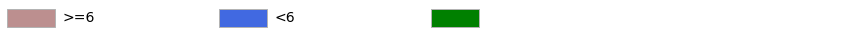

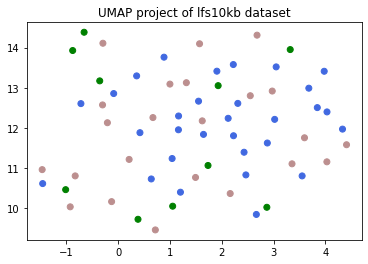

10 0.5 manhattan
UMAP(metric='manhattan', min_dist=0.5, n_neighbors=10, verbose=True)
Wed Dec 21 09:37:52 2022 Construct fuzzy simplicial set
Wed Dec 21 09:37:52 2022 Finding Nearest Neighbors
Wed Dec 21 09:37:52 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:37:52 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:37:53 2022 Finished embedding


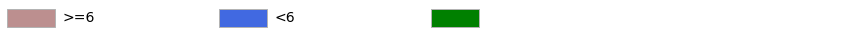

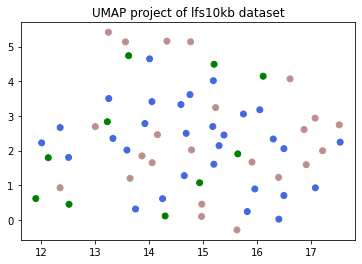

10 0.5 chebyshev
UMAP(metric='chebyshev', min_dist=0.5, n_neighbors=10, verbose=True)
Wed Dec 21 09:37:53 2022 Construct fuzzy simplicial set
Wed Dec 21 09:37:53 2022 Finding Nearest Neighbors
Wed Dec 21 09:37:53 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:37:53 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:37:54 2022 Finished embedding


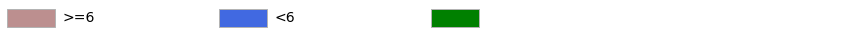

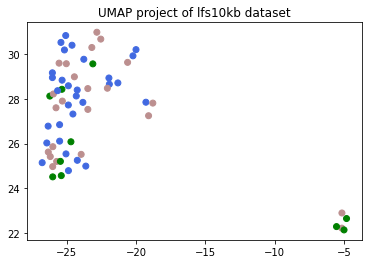

10 0.5 jaccard
UMAP(angular_rp_forest=True, metric='jaccard', min_dist=0.5, n_neighbors=10, verbose=True)
Wed Dec 21 09:37:54 2022 Construct fuzzy simplicial set
Wed Dec 21 09:37:54 2022 Finding Nearest Neighbors
Wed Dec 21 09:37:54 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:37:54 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:37:55 2022 Finished embedding


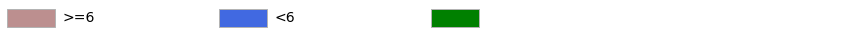

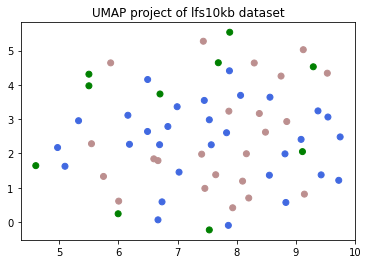

10 0.8 euclidean
UMAP(min_dist=0.8, n_neighbors=10, verbose=True)
Wed Dec 21 09:37:55 2022 Construct fuzzy simplicial set
Wed Dec 21 09:37:55 2022 Finding Nearest Neighbors
Wed Dec 21 09:37:55 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:37:55 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:37:56 2022 Finished embedding


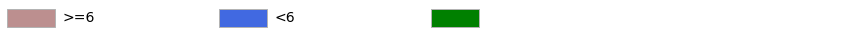

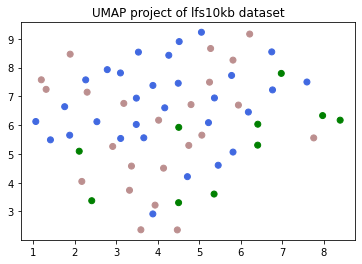

10 0.8 manhattan
UMAP(metric='manhattan', min_dist=0.8, n_neighbors=10, verbose=True)
Wed Dec 21 09:37:56 2022 Construct fuzzy simplicial set
Wed Dec 21 09:37:56 2022 Finding Nearest Neighbors
Wed Dec 21 09:37:56 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:37:56 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:37:58 2022 Finished embedding


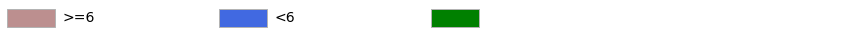

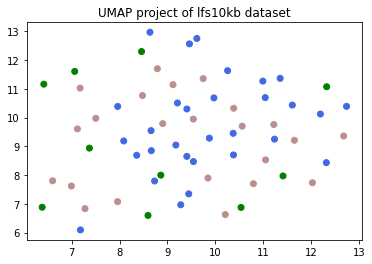

10 0.8 chebyshev
UMAP(metric='chebyshev', min_dist=0.8, n_neighbors=10, verbose=True)
Wed Dec 21 09:37:58 2022 Construct fuzzy simplicial set
Wed Dec 21 09:37:58 2022 Finding Nearest Neighbors
Wed Dec 21 09:37:58 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:37:58 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:37:59 2022 Finished embedding


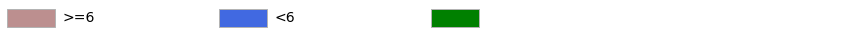

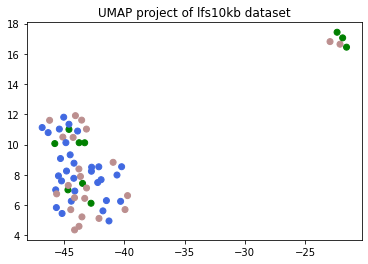

10 0.8 jaccard
UMAP(angular_rp_forest=True, metric='jaccard', min_dist=0.8, n_neighbors=10, verbose=True)
Wed Dec 21 09:37:59 2022 Construct fuzzy simplicial set
Wed Dec 21 09:37:59 2022 Finding Nearest Neighbors
Wed Dec 21 09:37:59 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:37:59 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:38:00 2022 Finished embedding


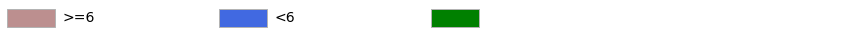

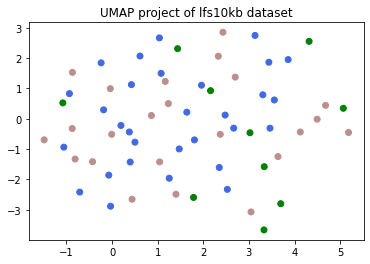

10 0.99 euclidean
UMAP(min_dist=0.99, n_neighbors=10, verbose=True)
Wed Dec 21 09:38:00 2022 Construct fuzzy simplicial set
Wed Dec 21 09:38:00 2022 Finding Nearest Neighbors
Wed Dec 21 09:38:00 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:38:00 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:38:01 2022 Finished embedding


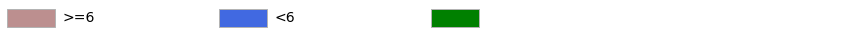

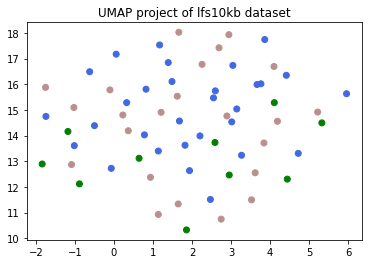

10 0.99 manhattan
UMAP(metric='manhattan', min_dist=0.99, n_neighbors=10, verbose=True)
Wed Dec 21 09:38:01 2022 Construct fuzzy simplicial set
Wed Dec 21 09:38:01 2022 Finding Nearest Neighbors
Wed Dec 21 09:38:01 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:38:01 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:38:02 2022 Finished embedding


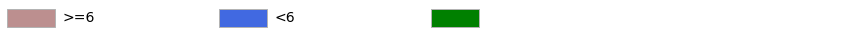

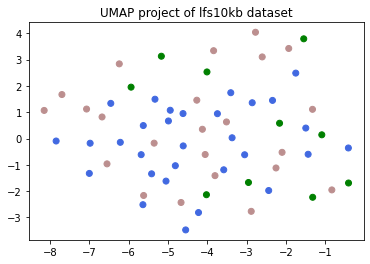

10 0.99 chebyshev
UMAP(metric='chebyshev', min_dist=0.99, n_neighbors=10, verbose=True)
Wed Dec 21 09:38:02 2022 Construct fuzzy simplicial set
Wed Dec 21 09:38:02 2022 Finding Nearest Neighbors
Wed Dec 21 09:38:02 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:38:02 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:38:03 2022 Finished embedding


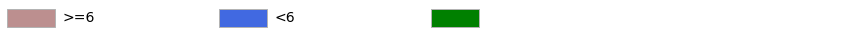

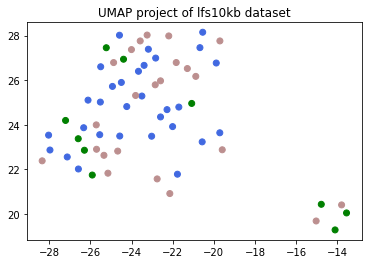

10 0.99 jaccard
UMAP(angular_rp_forest=True, metric='jaccard', min_dist=0.99, n_neighbors=10, verbose=True)
Wed Dec 21 09:38:03 2022 Construct fuzzy simplicial set
Wed Dec 21 09:38:04 2022 Finding Nearest Neighbors
Wed Dec 21 09:38:04 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:38:04 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:38:04 2022 Finished embedding


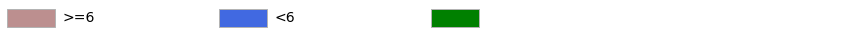

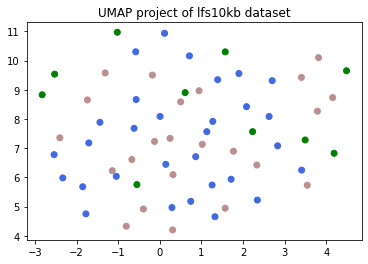

20 0.0 euclidean
UMAP(min_dist=0.0, n_neighbors=20, verbose=True)
Wed Dec 21 09:38:05 2022 Construct fuzzy simplicial set
Wed Dec 21 09:38:05 2022 Finding Nearest Neighbors
Wed Dec 21 09:38:05 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:38:05 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:38:06 2022 Finished embedding


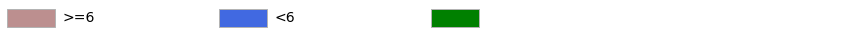

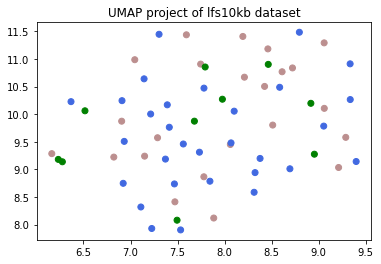

20 0.0 manhattan
UMAP(metric='manhattan', min_dist=0.0, n_neighbors=20, verbose=True)
Wed Dec 21 09:38:06 2022 Construct fuzzy simplicial set
Wed Dec 21 09:38:06 2022 Finding Nearest Neighbors
Wed Dec 21 09:38:06 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:38:06 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:38:07 2022 Finished embedding


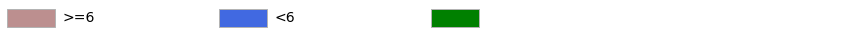

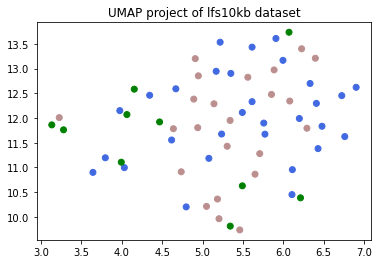

20 0.0 chebyshev
UMAP(metric='chebyshev', min_dist=0.0, n_neighbors=20, verbose=True)
Wed Dec 21 09:38:07 2022 Construct fuzzy simplicial set
Wed Dec 21 09:38:07 2022 Finding Nearest Neighbors
Wed Dec 21 09:38:07 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:38:07 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:38:08 2022 Finished embedding


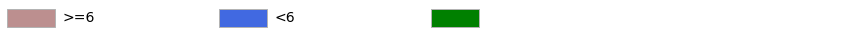

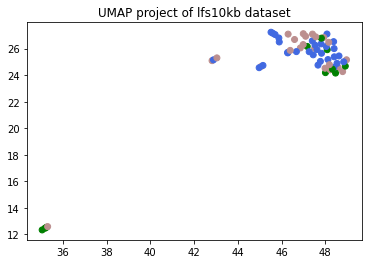

20 0.0 jaccard
UMAP(angular_rp_forest=True, metric='jaccard', min_dist=0.0, n_neighbors=20, verbose=True)
Wed Dec 21 09:38:08 2022 Construct fuzzy simplicial set
Wed Dec 21 09:38:08 2022 Finding Nearest Neighbors
Wed Dec 21 09:38:08 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:38:08 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:38:09 2022 Finished embedding


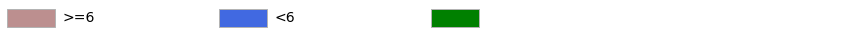

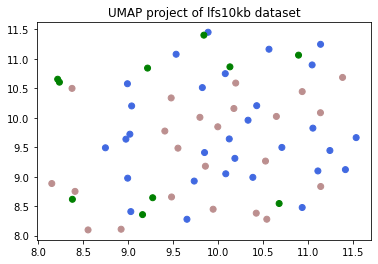

20 0.1 euclidean
UMAP(n_neighbors=20, verbose=True)
Wed Dec 21 09:38:09 2022 Construct fuzzy simplicial set
Wed Dec 21 09:38:09 2022 Finding Nearest Neighbors
Wed Dec 21 09:38:09 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:38:09 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:38:10 2022 Finished embedding


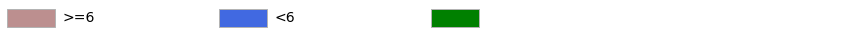

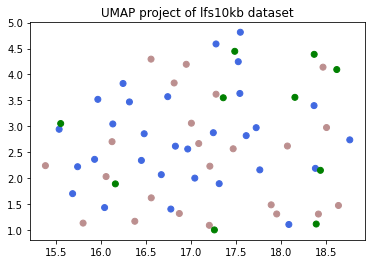

20 0.1 manhattan
UMAP(metric='manhattan', n_neighbors=20, verbose=True)
Wed Dec 21 09:38:10 2022 Construct fuzzy simplicial set
Wed Dec 21 09:38:10 2022 Finding Nearest Neighbors
Wed Dec 21 09:38:10 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:38:11 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:38:12 2022 Finished embedding


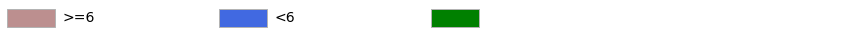

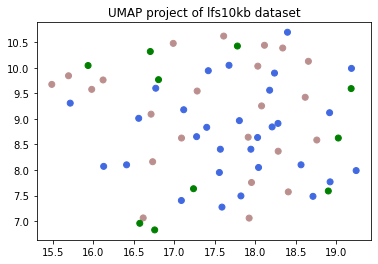

20 0.1 chebyshev
UMAP(metric='chebyshev', n_neighbors=20, verbose=True)
Wed Dec 21 09:38:12 2022 Construct fuzzy simplicial set
Wed Dec 21 09:38:12 2022 Finding Nearest Neighbors
Wed Dec 21 09:38:12 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:38:12 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:38:13 2022 Finished embedding


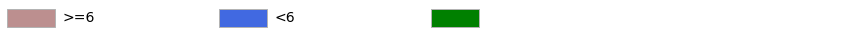

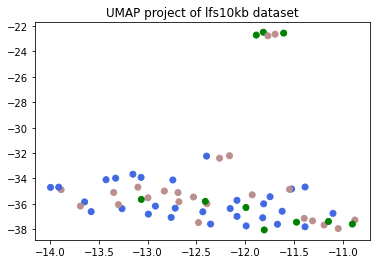

20 0.1 jaccard
UMAP(angular_rp_forest=True, metric='jaccard', n_neighbors=20, verbose=True)
Wed Dec 21 09:38:13 2022 Construct fuzzy simplicial set
Wed Dec 21 09:38:13 2022 Finding Nearest Neighbors
Wed Dec 21 09:38:13 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:38:13 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:38:14 2022 Finished embedding


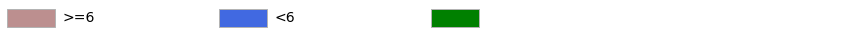

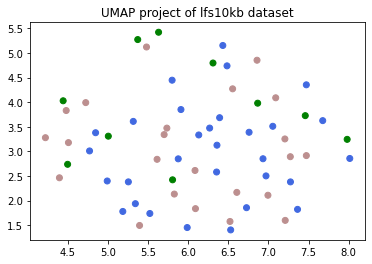

20 0.25 euclidean
UMAP(min_dist=0.25, n_neighbors=20, verbose=True)
Wed Dec 21 09:38:14 2022 Construct fuzzy simplicial set
Wed Dec 21 09:38:14 2022 Finding Nearest Neighbors
Wed Dec 21 09:38:14 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:38:14 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:38:15 2022 Finished embedding


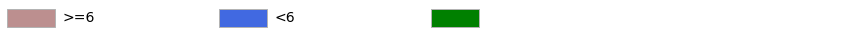

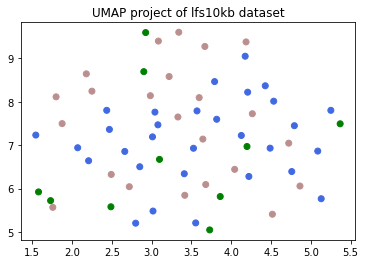

20 0.25 manhattan
UMAP(metric='manhattan', min_dist=0.25, n_neighbors=20, verbose=True)
Wed Dec 21 09:38:15 2022 Construct fuzzy simplicial set
Wed Dec 21 09:38:15 2022 Finding Nearest Neighbors
Wed Dec 21 09:38:15 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:38:15 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:38:16 2022 Finished embedding


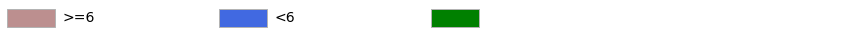

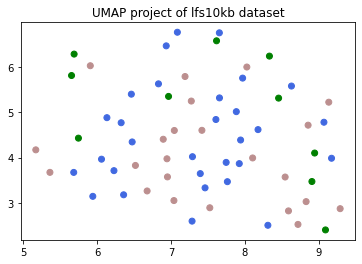

20 0.25 chebyshev
UMAP(metric='chebyshev', min_dist=0.25, n_neighbors=20, verbose=True)
Wed Dec 21 09:38:16 2022 Construct fuzzy simplicial set
Wed Dec 21 09:38:16 2022 Finding Nearest Neighbors
Wed Dec 21 09:38:16 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:38:16 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:38:17 2022 Finished embedding


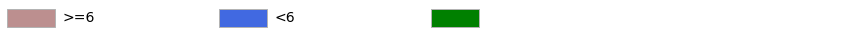

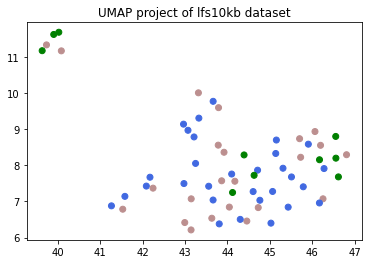

20 0.25 jaccard
UMAP(angular_rp_forest=True, metric='jaccard', min_dist=0.25, n_neighbors=20, verbose=True)
Wed Dec 21 09:38:18 2022 Construct fuzzy simplicial set
Wed Dec 21 09:38:18 2022 Finding Nearest Neighbors
Wed Dec 21 09:38:18 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:38:18 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:38:19 2022 Finished embedding


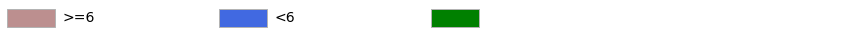

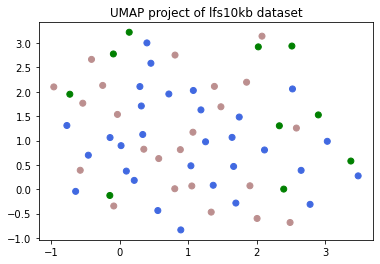

20 0.5 euclidean
UMAP(min_dist=0.5, n_neighbors=20, verbose=True)
Wed Dec 21 09:38:19 2022 Construct fuzzy simplicial set
Wed Dec 21 09:38:19 2022 Finding Nearest Neighbors
Wed Dec 21 09:38:19 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:38:19 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:38:20 2022 Finished embedding


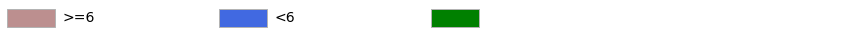

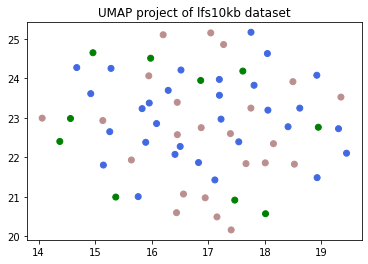

20 0.5 manhattan
UMAP(metric='manhattan', min_dist=0.5, n_neighbors=20, verbose=True)
Wed Dec 21 09:38:20 2022 Construct fuzzy simplicial set
Wed Dec 21 09:38:20 2022 Finding Nearest Neighbors
Wed Dec 21 09:38:20 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:38:20 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:38:21 2022 Finished embedding


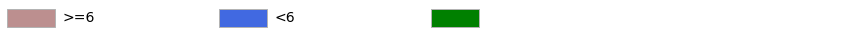

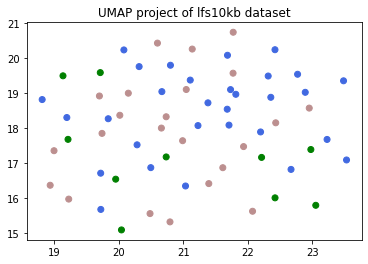

20 0.5 chebyshev
UMAP(metric='chebyshev', min_dist=0.5, n_neighbors=20, verbose=True)
Wed Dec 21 09:38:21 2022 Construct fuzzy simplicial set
Wed Dec 21 09:38:21 2022 Finding Nearest Neighbors
Wed Dec 21 09:38:21 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:38:21 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:38:22 2022 Finished embedding


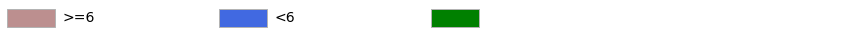

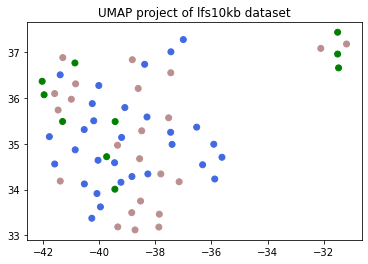

20 0.5 jaccard
UMAP(angular_rp_forest=True, metric='jaccard', min_dist=0.5, n_neighbors=20, verbose=True)
Wed Dec 21 09:38:22 2022 Construct fuzzy simplicial set
Wed Dec 21 09:38:22 2022 Finding Nearest Neighbors
Wed Dec 21 09:38:22 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:38:22 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:38:24 2022 Finished embedding


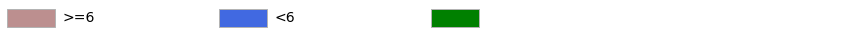

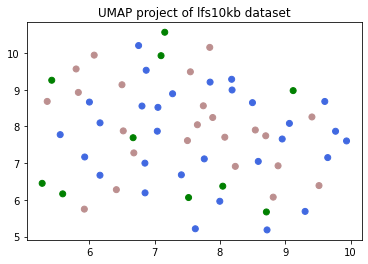

20 0.8 euclidean
UMAP(min_dist=0.8, n_neighbors=20, verbose=True)
Wed Dec 21 09:38:24 2022 Construct fuzzy simplicial set
Wed Dec 21 09:38:24 2022 Finding Nearest Neighbors
Wed Dec 21 09:38:24 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:38:24 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:38:25 2022 Finished embedding


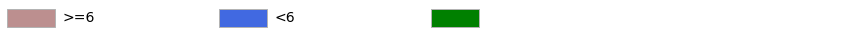

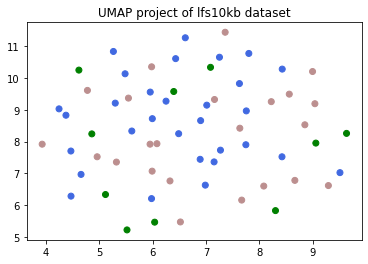

20 0.8 manhattan
UMAP(metric='manhattan', min_dist=0.8, n_neighbors=20, verbose=True)
Wed Dec 21 09:38:25 2022 Construct fuzzy simplicial set
Wed Dec 21 09:38:25 2022 Finding Nearest Neighbors
Wed Dec 21 09:38:25 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:38:25 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:38:26 2022 Finished embedding


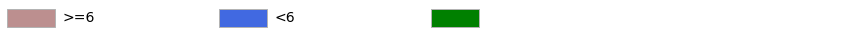

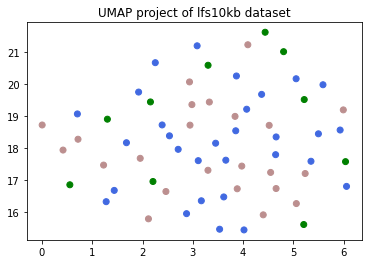

20 0.8 chebyshev
UMAP(metric='chebyshev', min_dist=0.8, n_neighbors=20, verbose=True)
Wed Dec 21 09:38:27 2022 Construct fuzzy simplicial set
Wed Dec 21 09:38:27 2022 Finding Nearest Neighbors
Wed Dec 21 09:38:27 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:38:27 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:38:28 2022 Finished embedding


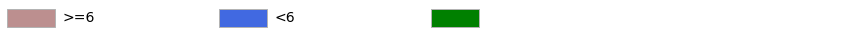

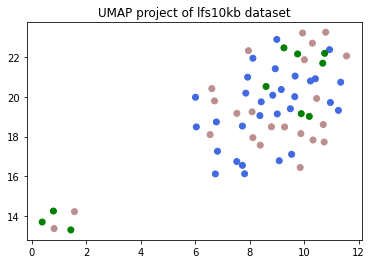

20 0.8 jaccard
UMAP(angular_rp_forest=True, metric='jaccard', min_dist=0.8, n_neighbors=20, verbose=True)
Wed Dec 21 09:38:28 2022 Construct fuzzy simplicial set
Wed Dec 21 09:38:28 2022 Finding Nearest Neighbors
Wed Dec 21 09:38:28 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:38:28 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:38:29 2022 Finished embedding


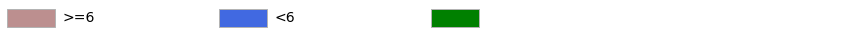

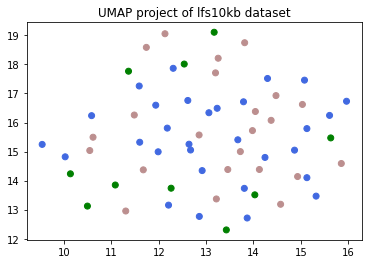

20 0.99 euclidean
UMAP(min_dist=0.99, n_neighbors=20, verbose=True)
Wed Dec 21 09:38:29 2022 Construct fuzzy simplicial set
Wed Dec 21 09:38:29 2022 Finding Nearest Neighbors
Wed Dec 21 09:38:29 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:38:29 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:38:30 2022 Finished embedding


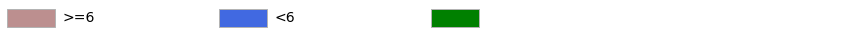

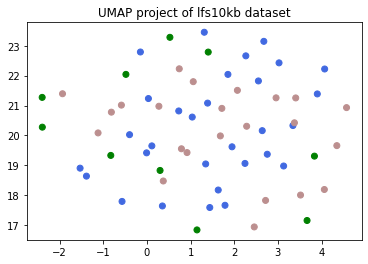

20 0.99 manhattan
UMAP(metric='manhattan', min_dist=0.99, n_neighbors=20, verbose=True)
Wed Dec 21 09:38:30 2022 Construct fuzzy simplicial set
Wed Dec 21 09:38:30 2022 Finding Nearest Neighbors
Wed Dec 21 09:38:30 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:38:30 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:38:31 2022 Finished embedding


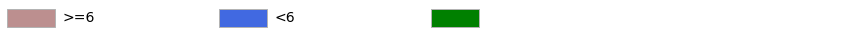

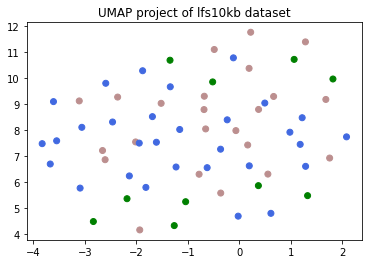

20 0.99 chebyshev
UMAP(metric='chebyshev', min_dist=0.99, n_neighbors=20, verbose=True)
Wed Dec 21 09:38:31 2022 Construct fuzzy simplicial set
Wed Dec 21 09:38:31 2022 Finding Nearest Neighbors
Wed Dec 21 09:38:31 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:38:31 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:38:32 2022 Finished embedding


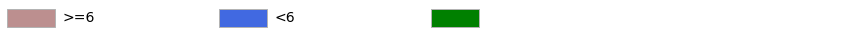

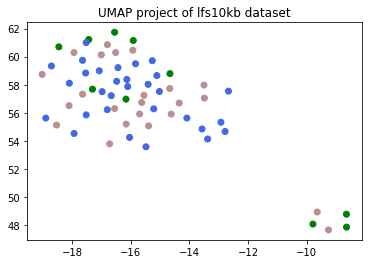

20 0.99 jaccard
UMAP(angular_rp_forest=True, metric='jaccard', min_dist=0.99, n_neighbors=20, verbose=True)
Wed Dec 21 09:38:32 2022 Construct fuzzy simplicial set
Wed Dec 21 09:38:33 2022 Finding Nearest Neighbors
Wed Dec 21 09:38:33 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:38:33 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:38:33 2022 Finished embedding


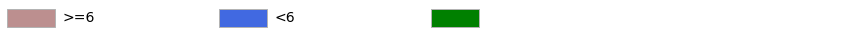

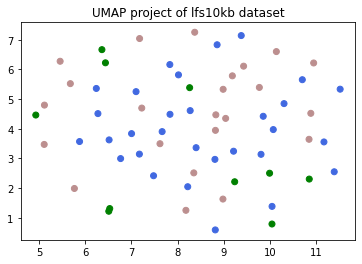

50 0.0 euclidean
UMAP(min_dist=0.0, n_neighbors=50, verbose=True)
Wed Dec 21 09:38:34 2022 Construct fuzzy simplicial set
Wed Dec 21 09:38:34 2022 Finding Nearest Neighbors
Wed Dec 21 09:38:34 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:38:34 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:38:35 2022 Finished embedding


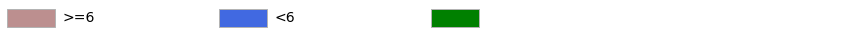

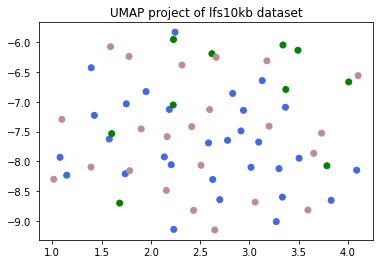

50 0.0 manhattan
UMAP(metric='manhattan', min_dist=0.0, n_neighbors=50, verbose=True)
Wed Dec 21 09:38:35 2022 Construct fuzzy simplicial set
Wed Dec 21 09:38:35 2022 Finding Nearest Neighbors
Wed Dec 21 09:38:35 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:38:35 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:38:36 2022 Finished embedding


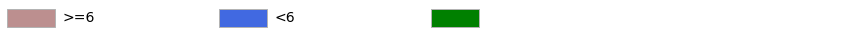

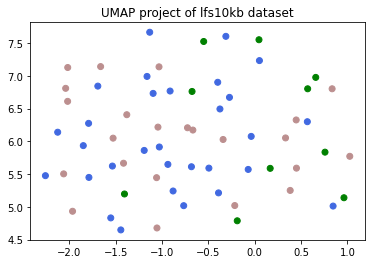

50 0.0 chebyshev
UMAP(metric='chebyshev', min_dist=0.0, n_neighbors=50, verbose=True)
Wed Dec 21 09:38:36 2022 Construct fuzzy simplicial set
Wed Dec 21 09:38:36 2022 Finding Nearest Neighbors
Wed Dec 21 09:38:36 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:38:36 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:38:37 2022 Finished embedding


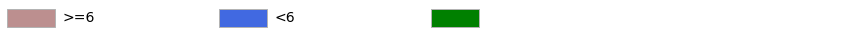

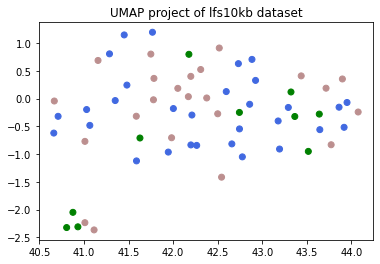

50 0.0 jaccard
UMAP(angular_rp_forest=True, metric='jaccard', min_dist=0.0, n_neighbors=50, verbose=True)
Wed Dec 21 09:38:37 2022 Construct fuzzy simplicial set
Wed Dec 21 09:38:37 2022 Finding Nearest Neighbors
Wed Dec 21 09:38:37 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:38:37 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:38:38 2022 Finished embedding


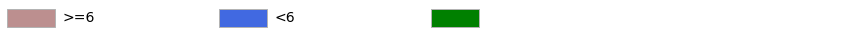

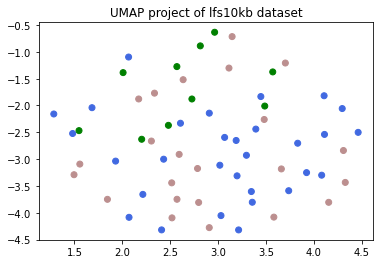

50 0.1 euclidean
UMAP(n_neighbors=50, verbose=True)
Wed Dec 21 09:38:38 2022 Construct fuzzy simplicial set
Wed Dec 21 09:38:38 2022 Finding Nearest Neighbors
Wed Dec 21 09:38:38 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:38:38 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:38:40 2022 Finished embedding


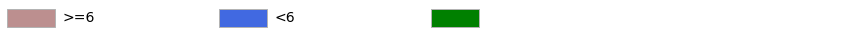

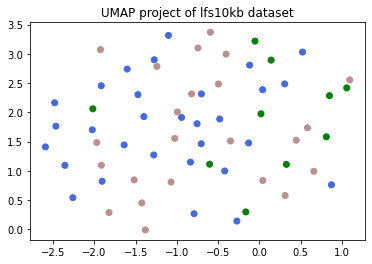

50 0.1 manhattan
UMAP(metric='manhattan', n_neighbors=50, verbose=True)
Wed Dec 21 09:38:40 2022 Construct fuzzy simplicial set
Wed Dec 21 09:38:40 2022 Finding Nearest Neighbors
Wed Dec 21 09:38:40 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:38:40 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:38:41 2022 Finished embedding


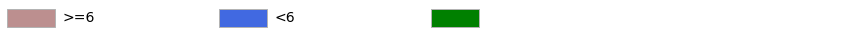

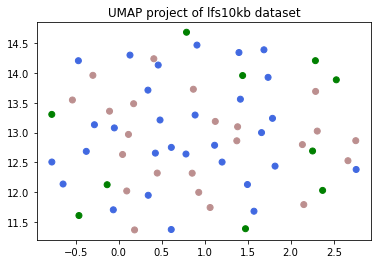

50 0.1 chebyshev
UMAP(metric='chebyshev', n_neighbors=50, verbose=True)
Wed Dec 21 09:38:41 2022 Construct fuzzy simplicial set
Wed Dec 21 09:38:41 2022 Finding Nearest Neighbors
Wed Dec 21 09:38:41 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:38:41 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:38:42 2022 Finished embedding


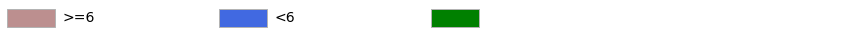

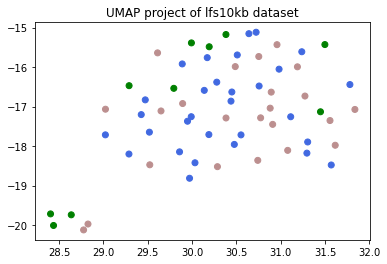

50 0.1 jaccard
UMAP(angular_rp_forest=True, metric='jaccard', n_neighbors=50, verbose=True)
Wed Dec 21 09:38:42 2022 Construct fuzzy simplicial set
Wed Dec 21 09:38:42 2022 Finding Nearest Neighbors
Wed Dec 21 09:38:42 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:38:42 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:38:43 2022 Finished embedding


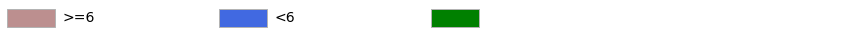

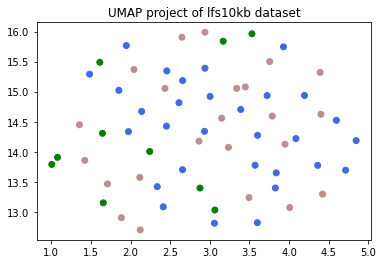

50 0.25 euclidean
UMAP(min_dist=0.25, n_neighbors=50, verbose=True)
Wed Dec 21 09:38:43 2022 Construct fuzzy simplicial set
Wed Dec 21 09:38:43 2022 Finding Nearest Neighbors
Wed Dec 21 09:38:43 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:38:43 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:38:44 2022 Finished embedding


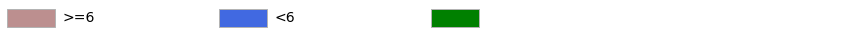

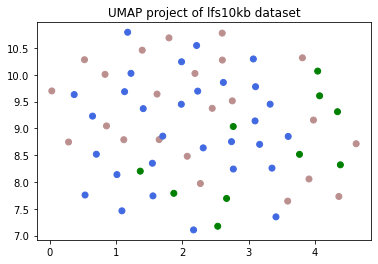

50 0.25 manhattan
UMAP(metric='manhattan', min_dist=0.25, n_neighbors=50, verbose=True)
Wed Dec 21 09:38:44 2022 Construct fuzzy simplicial set
Wed Dec 21 09:38:45 2022 Finding Nearest Neighbors
Wed Dec 21 09:38:45 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:38:45 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:38:46 2022 Finished embedding


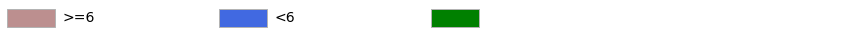

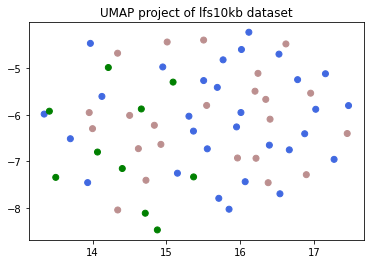

50 0.25 chebyshev
UMAP(metric='chebyshev', min_dist=0.25, n_neighbors=50, verbose=True)
Wed Dec 21 09:38:46 2022 Construct fuzzy simplicial set
Wed Dec 21 09:38:46 2022 Finding Nearest Neighbors
Wed Dec 21 09:38:46 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:38:46 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:38:47 2022 Finished embedding


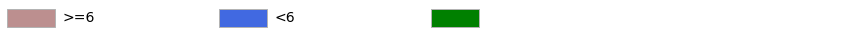

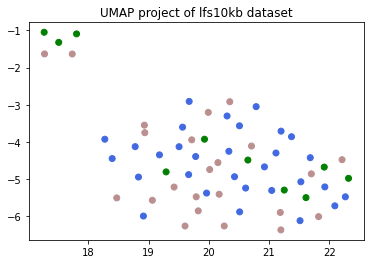

50 0.25 jaccard
UMAP(angular_rp_forest=True, metric='jaccard', min_dist=0.25, n_neighbors=50, verbose=True)
Wed Dec 21 09:38:47 2022 Construct fuzzy simplicial set
Wed Dec 21 09:38:47 2022 Finding Nearest Neighbors
Wed Dec 21 09:38:47 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:38:47 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:38:48 2022 Finished embedding


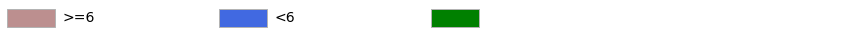

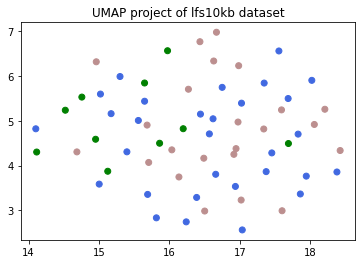

50 0.5 euclidean
UMAP(min_dist=0.5, n_neighbors=50, verbose=True)
Wed Dec 21 09:38:48 2022 Construct fuzzy simplicial set
Wed Dec 21 09:38:48 2022 Finding Nearest Neighbors
Wed Dec 21 09:38:48 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:38:48 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:38:49 2022 Finished embedding


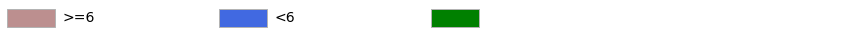

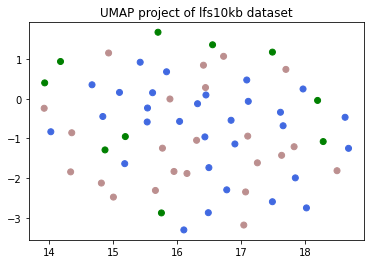

50 0.5 manhattan
UMAP(metric='manhattan', min_dist=0.5, n_neighbors=50, verbose=True)
Wed Dec 21 09:38:50 2022 Construct fuzzy simplicial set
Wed Dec 21 09:38:50 2022 Finding Nearest Neighbors
Wed Dec 21 09:38:50 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:38:50 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:38:51 2022 Finished embedding


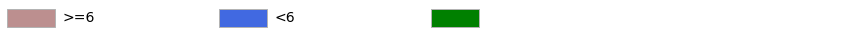

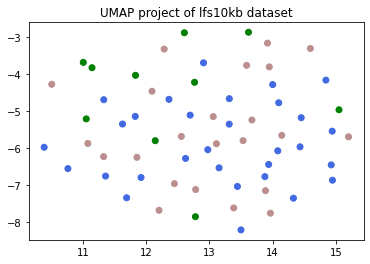

50 0.5 chebyshev
UMAP(metric='chebyshev', min_dist=0.5, n_neighbors=50, verbose=True)
Wed Dec 21 09:38:51 2022 Construct fuzzy simplicial set
Wed Dec 21 09:38:51 2022 Finding Nearest Neighbors
Wed Dec 21 09:38:51 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:38:51 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:38:52 2022 Finished embedding


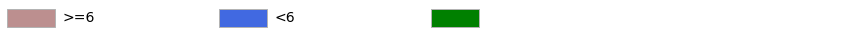

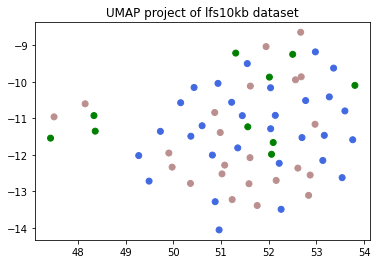

50 0.5 jaccard
UMAP(angular_rp_forest=True, metric='jaccard', min_dist=0.5, n_neighbors=50, verbose=True)
Wed Dec 21 09:38:52 2022 Construct fuzzy simplicial set
Wed Dec 21 09:38:52 2022 Finding Nearest Neighbors
Wed Dec 21 09:38:52 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:38:52 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:38:53 2022 Finished embedding


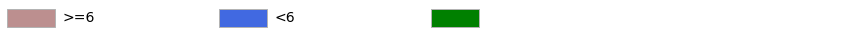

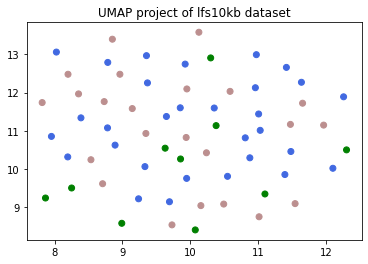

50 0.8 euclidean
UMAP(min_dist=0.8, n_neighbors=50, verbose=True)
Wed Dec 21 09:38:53 2022 Construct fuzzy simplicial set
Wed Dec 21 09:38:53 2022 Finding Nearest Neighbors
Wed Dec 21 09:38:53 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:38:53 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:38:54 2022 Finished embedding


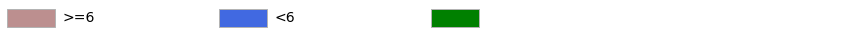

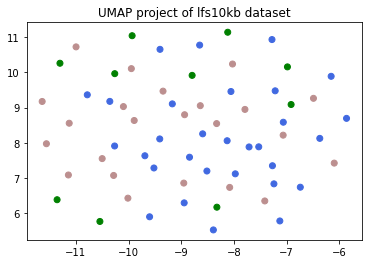

50 0.8 manhattan
UMAP(metric='manhattan', min_dist=0.8, n_neighbors=50, verbose=True)
Wed Dec 21 09:38:54 2022 Construct fuzzy simplicial set
Wed Dec 21 09:38:55 2022 Finding Nearest Neighbors
Wed Dec 21 09:38:55 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:38:55 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:38:56 2022 Finished embedding


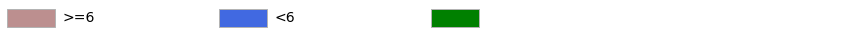

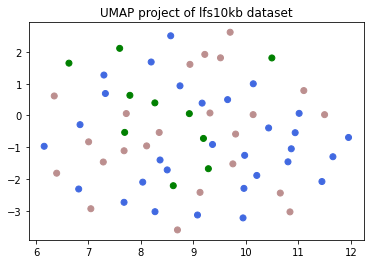

50 0.8 chebyshev
UMAP(metric='chebyshev', min_dist=0.8, n_neighbors=50, verbose=True)
Wed Dec 21 09:38:56 2022 Construct fuzzy simplicial set
Wed Dec 21 09:38:56 2022 Finding Nearest Neighbors
Wed Dec 21 09:38:56 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:38:56 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:38:57 2022 Finished embedding


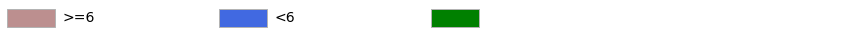

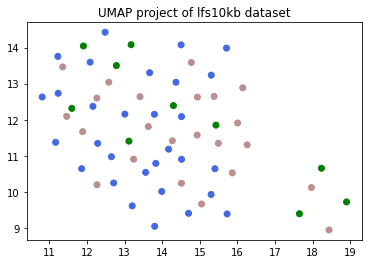

50 0.8 jaccard
UMAP(angular_rp_forest=True, metric='jaccard', min_dist=0.8, n_neighbors=50, verbose=True)
Wed Dec 21 09:38:57 2022 Construct fuzzy simplicial set
Wed Dec 21 09:38:57 2022 Finding Nearest Neighbors
Wed Dec 21 09:38:57 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:38:57 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:38:58 2022 Finished embedding


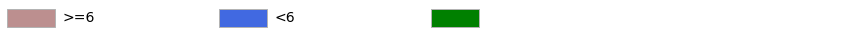

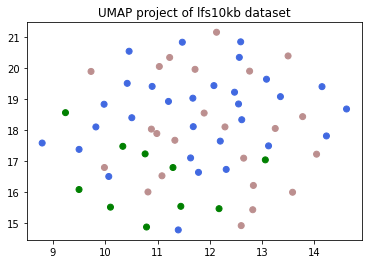

50 0.99 euclidean
UMAP(min_dist=0.99, n_neighbors=50, verbose=True)
Wed Dec 21 09:38:58 2022 Construct fuzzy simplicial set
Wed Dec 21 09:38:58 2022 Finding Nearest Neighbors
Wed Dec 21 09:38:58 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:38:58 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:38:59 2022 Finished embedding


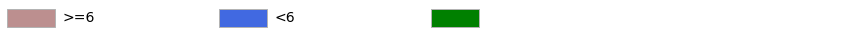

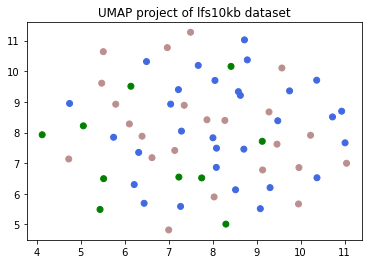

50 0.99 manhattan
UMAP(metric='manhattan', min_dist=0.99, n_neighbors=50, verbose=True)
Wed Dec 21 09:38:59 2022 Construct fuzzy simplicial set
Wed Dec 21 09:38:59 2022 Finding Nearest Neighbors
Wed Dec 21 09:38:59 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:38:59 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:39:00 2022 Finished embedding


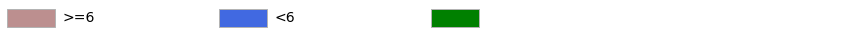

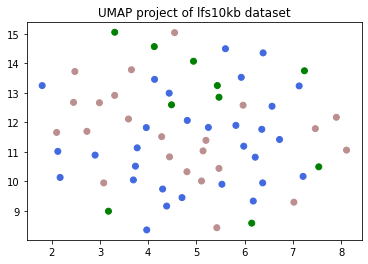

50 0.99 chebyshev
UMAP(metric='chebyshev', min_dist=0.99, n_neighbors=50, verbose=True)
Wed Dec 21 09:39:01 2022 Construct fuzzy simplicial set
Wed Dec 21 09:39:01 2022 Finding Nearest Neighbors
Wed Dec 21 09:39:01 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:39:01 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:39:02 2022 Finished embedding


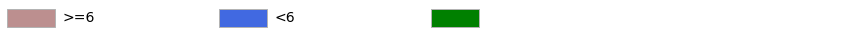

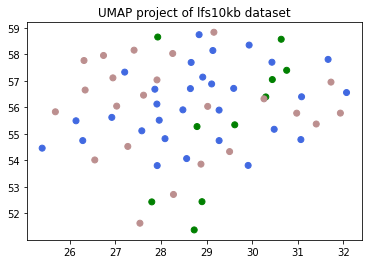

50 0.99 jaccard
UMAP(angular_rp_forest=True, metric='jaccard', min_dist=0.99, n_neighbors=50, verbose=True)
Wed Dec 21 09:39:02 2022 Construct fuzzy simplicial set
Wed Dec 21 09:39:02 2022 Finding Nearest Neighbors
Wed Dec 21 09:39:02 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:39:02 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:39:03 2022 Finished embedding


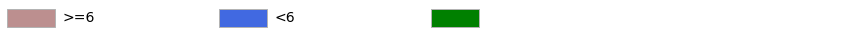

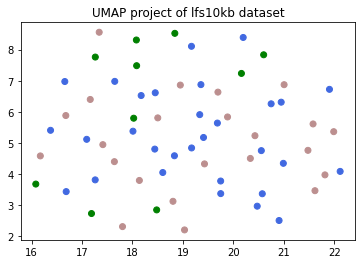

100 0.0 euclidean
UMAP(min_dist=0.0, n_neighbors=100, verbose=True)
Wed Dec 21 09:39:03 2022 Construct fuzzy simplicial set
Wed Dec 21 09:39:03 2022 Finding Nearest Neighbors
Wed Dec 21 09:39:03 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:39:03 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:39:04 2022 Finished embedding


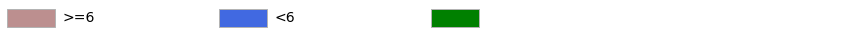

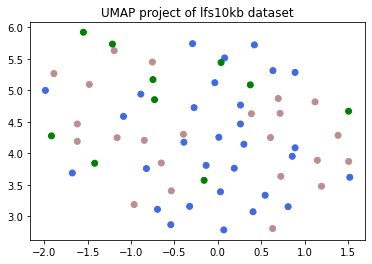

100 0.0 manhattan
UMAP(metric='manhattan', min_dist=0.0, n_neighbors=100, verbose=True)
Wed Dec 21 09:39:04 2022 Construct fuzzy simplicial set
Wed Dec 21 09:39:04 2022 Finding Nearest Neighbors
Wed Dec 21 09:39:04 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:39:04 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:39:05 2022 Finished embedding


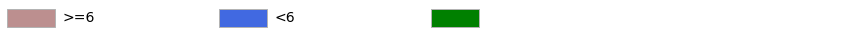

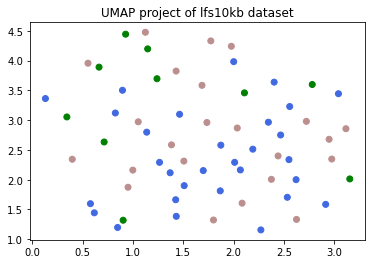

100 0.0 chebyshev
UMAP(metric='chebyshev', min_dist=0.0, n_neighbors=100, verbose=True)
Wed Dec 21 09:39:05 2022 Construct fuzzy simplicial set
Wed Dec 21 09:39:05 2022 Finding Nearest Neighbors
Wed Dec 21 09:39:05 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:39:05 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:39:07 2022 Finished embedding


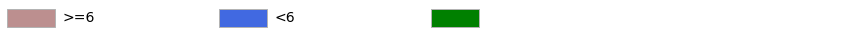

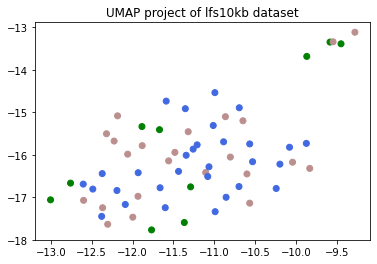

100 0.0 jaccard
UMAP(angular_rp_forest=True, metric='jaccard', min_dist=0.0, n_neighbors=100, verbose=True)
Wed Dec 21 09:39:07 2022 Construct fuzzy simplicial set
Wed Dec 21 09:39:07 2022 Finding Nearest Neighbors
Wed Dec 21 09:39:07 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:39:07 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:39:08 2022 Finished embedding


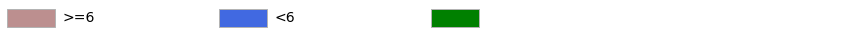

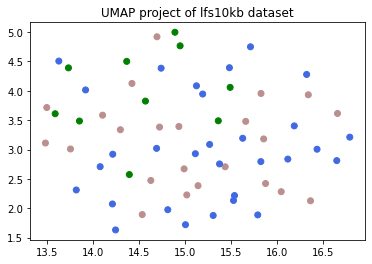

100 0.1 euclidean
UMAP(n_neighbors=100, verbose=True)
Wed Dec 21 09:39:08 2022 Construct fuzzy simplicial set
Wed Dec 21 09:39:08 2022 Finding Nearest Neighbors
Wed Dec 21 09:39:08 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:39:08 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:39:09 2022 Finished embedding


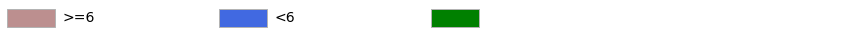

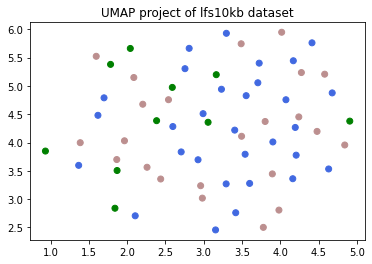

100 0.1 manhattan
UMAP(metric='manhattan', n_neighbors=100, verbose=True)
Wed Dec 21 09:39:09 2022 Construct fuzzy simplicial set
Wed Dec 21 09:39:09 2022 Finding Nearest Neighbors
Wed Dec 21 09:39:09 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:39:09 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:39:10 2022 Finished embedding


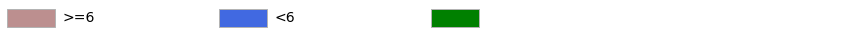

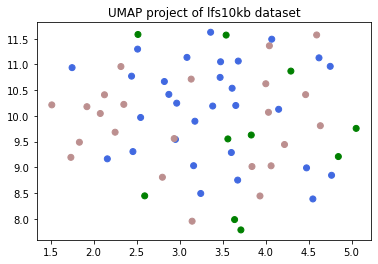

100 0.1 chebyshev
UMAP(metric='chebyshev', n_neighbors=100, verbose=True)
Wed Dec 21 09:39:10 2022 Construct fuzzy simplicial set
Wed Dec 21 09:39:10 2022 Finding Nearest Neighbors
Wed Dec 21 09:39:10 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:39:10 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:39:11 2022 Finished embedding


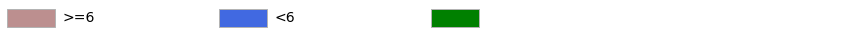

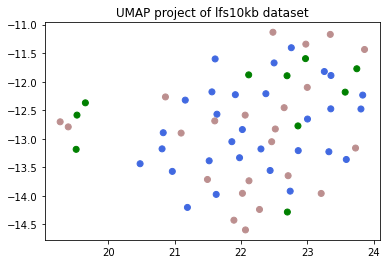

100 0.1 jaccard
UMAP(angular_rp_forest=True, metric='jaccard', n_neighbors=100, verbose=True)
Wed Dec 21 09:39:11 2022 Construct fuzzy simplicial set
Wed Dec 21 09:39:12 2022 Finding Nearest Neighbors
Wed Dec 21 09:39:12 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:39:12 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:39:13 2022 Finished embedding


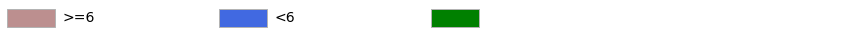

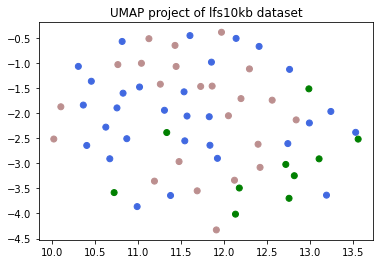

100 0.25 euclidean
UMAP(min_dist=0.25, n_neighbors=100, verbose=True)
Wed Dec 21 09:39:13 2022 Construct fuzzy simplicial set
Wed Dec 21 09:39:13 2022 Finding Nearest Neighbors
Wed Dec 21 09:39:13 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:39:13 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:39:14 2022 Finished embedding


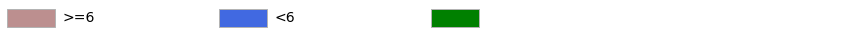

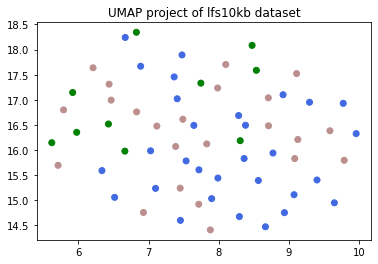

100 0.25 manhattan
UMAP(metric='manhattan', min_dist=0.25, n_neighbors=100, verbose=True)
Wed Dec 21 09:39:14 2022 Construct fuzzy simplicial set
Wed Dec 21 09:39:14 2022 Finding Nearest Neighbors
Wed Dec 21 09:39:14 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:39:14 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:39:15 2022 Finished embedding


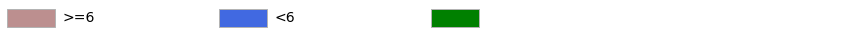

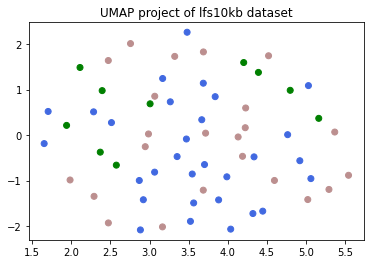

100 0.25 chebyshev
UMAP(metric='chebyshev', min_dist=0.25, n_neighbors=100, verbose=True)
Wed Dec 21 09:39:15 2022 Construct fuzzy simplicial set
Wed Dec 21 09:39:15 2022 Finding Nearest Neighbors
Wed Dec 21 09:39:15 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:39:15 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:39:16 2022 Finished embedding


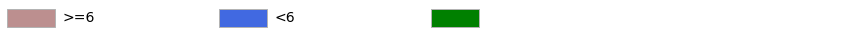

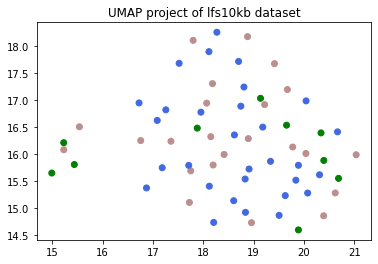

100 0.25 jaccard
UMAP(angular_rp_forest=True, metric='jaccard', min_dist=0.25, n_neighbors=100, verbose=True)
Wed Dec 21 09:39:16 2022 Construct fuzzy simplicial set
Wed Dec 21 09:39:16 2022 Finding Nearest Neighbors
Wed Dec 21 09:39:16 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:39:16 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:39:18 2022 Finished embedding


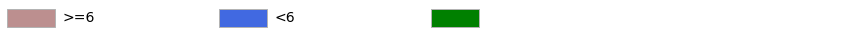

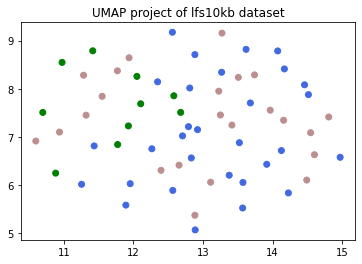

100 0.5 euclidean
UMAP(min_dist=0.5, n_neighbors=100, verbose=True)
Wed Dec 21 09:39:18 2022 Construct fuzzy simplicial set
Wed Dec 21 09:39:18 2022 Finding Nearest Neighbors
Wed Dec 21 09:39:18 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:39:18 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:39:19 2022 Finished embedding


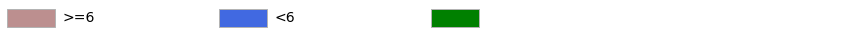

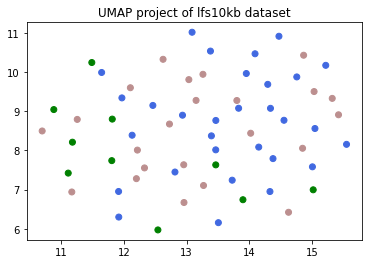

100 0.5 manhattan
UMAP(metric='manhattan', min_dist=0.5, n_neighbors=100, verbose=True)
Wed Dec 21 09:39:19 2022 Construct fuzzy simplicial set
Wed Dec 21 09:39:19 2022 Finding Nearest Neighbors
Wed Dec 21 09:39:19 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:39:19 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:39:21 2022 Finished embedding


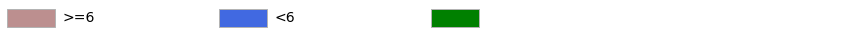

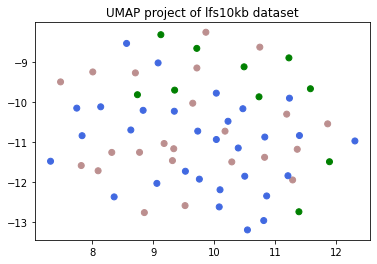

100 0.5 chebyshev
UMAP(metric='chebyshev', min_dist=0.5, n_neighbors=100, verbose=True)
Wed Dec 21 09:39:21 2022 Construct fuzzy simplicial set
Wed Dec 21 09:39:21 2022 Finding Nearest Neighbors
Wed Dec 21 09:39:21 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:39:21 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:39:22 2022 Finished embedding


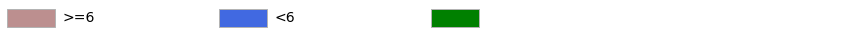

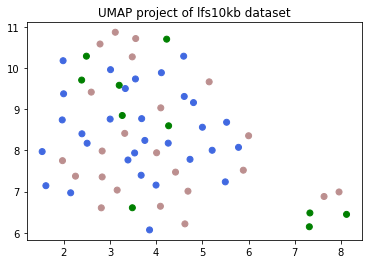

100 0.5 jaccard
UMAP(angular_rp_forest=True, metric='jaccard', min_dist=0.5, n_neighbors=100, verbose=True)
Wed Dec 21 09:39:22 2022 Construct fuzzy simplicial set
Wed Dec 21 09:39:22 2022 Finding Nearest Neighbors
Wed Dec 21 09:39:22 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:39:22 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:39:24 2022 Finished embedding


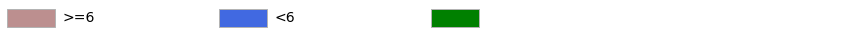

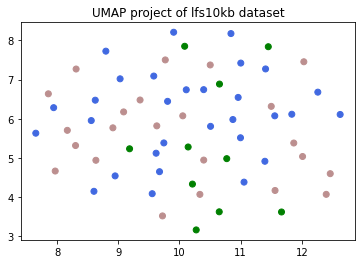

100 0.8 euclidean
UMAP(min_dist=0.8, n_neighbors=100, verbose=True)
Wed Dec 21 09:39:24 2022 Construct fuzzy simplicial set
Wed Dec 21 09:39:24 2022 Finding Nearest Neighbors
Wed Dec 21 09:39:24 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:39:24 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:39:25 2022 Finished embedding


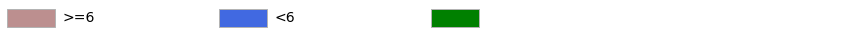

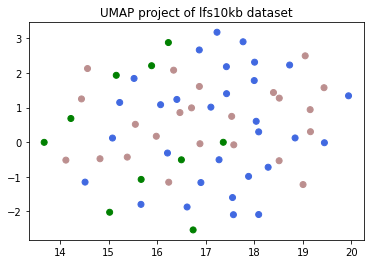

100 0.8 manhattan
UMAP(metric='manhattan', min_dist=0.8, n_neighbors=100, verbose=True)
Wed Dec 21 09:39:25 2022 Construct fuzzy simplicial set
Wed Dec 21 09:39:25 2022 Finding Nearest Neighbors
Wed Dec 21 09:39:25 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:39:25 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:39:26 2022 Finished embedding


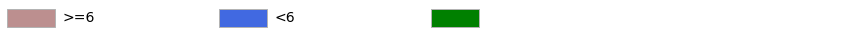

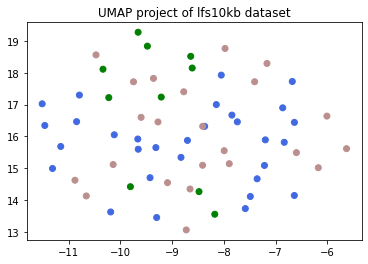

100 0.8 chebyshev
UMAP(metric='chebyshev', min_dist=0.8, n_neighbors=100, verbose=True)
Wed Dec 21 09:39:26 2022 Construct fuzzy simplicial set
Wed Dec 21 09:39:26 2022 Finding Nearest Neighbors
Wed Dec 21 09:39:26 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:39:26 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:39:27 2022 Finished embedding


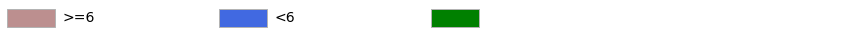

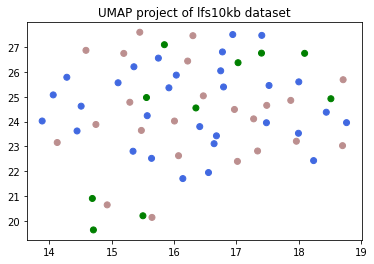

100 0.8 jaccard
UMAP(angular_rp_forest=True, metric='jaccard', min_dist=0.8, n_neighbors=100, verbose=True)
Wed Dec 21 09:39:28 2022 Construct fuzzy simplicial set
Wed Dec 21 09:39:28 2022 Finding Nearest Neighbors
Wed Dec 21 09:39:28 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:39:28 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:39:29 2022 Finished embedding


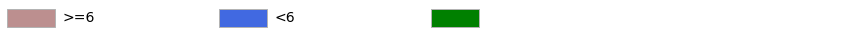

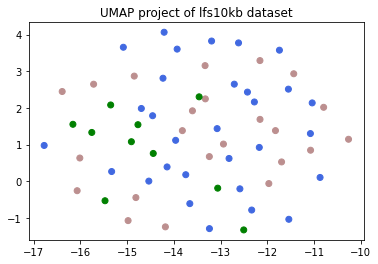

100 0.99 euclidean
UMAP(min_dist=0.99, n_neighbors=100, verbose=True)
Wed Dec 21 09:39:29 2022 Construct fuzzy simplicial set
Wed Dec 21 09:39:29 2022 Finding Nearest Neighbors
Wed Dec 21 09:39:29 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:39:29 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:39:30 2022 Finished embedding


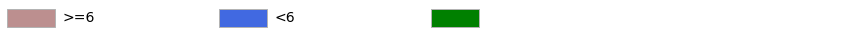

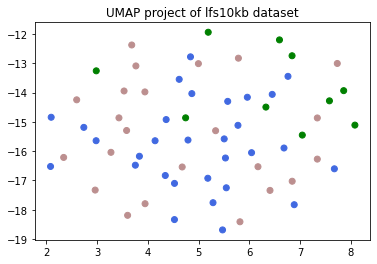

100 0.99 manhattan
UMAP(metric='manhattan', min_dist=0.99, n_neighbors=100, verbose=True)
Wed Dec 21 09:39:30 2022 Construct fuzzy simplicial set
Wed Dec 21 09:39:30 2022 Finding Nearest Neighbors
Wed Dec 21 09:39:30 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:39:30 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:39:31 2022 Finished embedding


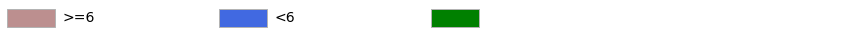

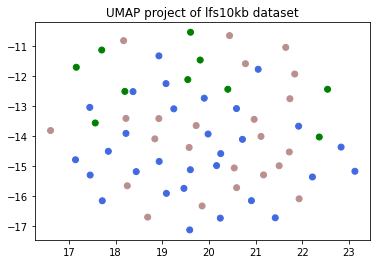

100 0.99 chebyshev
UMAP(metric='chebyshev', min_dist=0.99, n_neighbors=100, verbose=True)
Wed Dec 21 09:39:31 2022 Construct fuzzy simplicial set
Wed Dec 21 09:39:31 2022 Finding Nearest Neighbors
Wed Dec 21 09:39:31 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:39:31 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:39:32 2022 Finished embedding


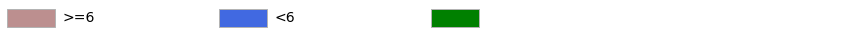

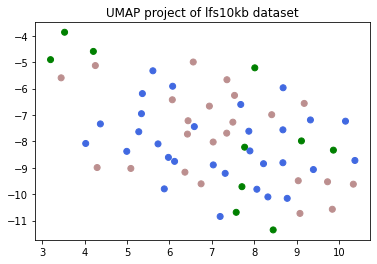

100 0.99 jaccard
UMAP(angular_rp_forest=True, metric='jaccard', min_dist=0.99, n_neighbors=100, verbose=True)
Wed Dec 21 09:39:33 2022 Construct fuzzy simplicial set
Wed Dec 21 09:39:33 2022 Finding Nearest Neighbors
Wed Dec 21 09:39:33 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:39:33 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:39:34 2022 Finished embedding


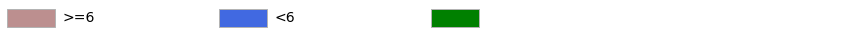

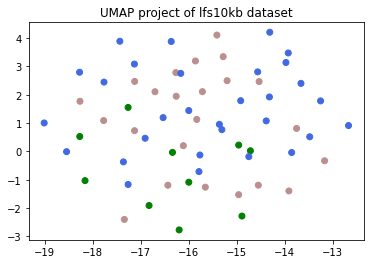

In [30]:
import umap
from umap import UMAP

#creates the many UMAPs of just lfs age of onset
def ageofonsetLFSUmap (df1, window_data, nn, md, metric):
    reducer = umap.UMAP(n_neighbors = nn, min_dist = md, n_components = 2, metric = metric, verbose = True)

    scaled_window_data = StandardScaler().fit_transform(window_data)
    embedding = reducer.fit_transform(window_data)
    embedding.shape
    listCancer = df1['ageofonset'].unique()
    enum = enumerate(listCancer)
    d = dict((j,i) for i,j in enum)

    #print(listCancer)

    colors=['#BC8F8F','#4169E1','#008000','#FF69B4','#4B0082',
             '#9370DB','#6B8E23','#800080','#FFDAB9','#EEE8AA',
            '#0000FF','#00008B','#FF00FF','#F08080','#C0C0C0',
            '#4682B4','#3CB371','#DC143C','#696969','#DCDCDC','#FFFFE0',
           '#CCCCFF', '#000000','#999999','#FF00FF','#BF9C11','#9EC6B8']

    col = colors[0:len(listCancer)]
    hexDict = dict()

    for i,j in zip(col,listCancer):
         hexDict[j] = i

    plot_colortable(hexDict)
    plt.show()

    plt.scatter(
        embedding[:,0],
        embedding[:,1],
        c=[col[x] for x in df1['ageofonset'].map(d)]
    )

    plt.title('UMAP project of lfs10kb dataset')
    plt.show()

    
nneigh = [2, 5, 10, 20, 50, 100]
minD = [0.0, 0.1, 0.25, 0.5, 0.8, 0.99]
ncomp = [1,2,3]
metrics = ['euclidean', 'manhattan', 'chebyshev', 'jaccard']

print(mergeMatrix.columns)

for nn in nneigh:
    for md in minD:
        for m in metrics:
            print(nn,md,m)
            ageofonsetLFSUmap(df1,window_data,nn, md,m)


In [31]:
"""
UMAP KICS and LFS
"""

#merge the clinical file column and the window df
def formatClinicalMerge(df1, Uberdf, dfColName):
    idList = df1.index
    featList = []
    dropList = []

    for i in idList:
        test = Uberdf.loc[Uberdf['id']==i, dfColName]

        if test.empty:
            #drop the id that can't be found
            dropList.append(i)
        else:
            #add the id found's cancer diagnosis
            featList.append(test.iloc[0]) 

    df1 = df1.drop(dropList)
    df1[dfColName] = featList

    return df1

In [32]:
colors=['#BC8F8F','#4169E1','#008000','#FF69B4','#4B0082',
         '#9370DB','#6B8E23','#800080','#FFDAB9','#EEE8AA',
        '#0000FF','#00008B','#FF00FF','#F08080','#C0C0C0',
        '#4682B4','#3CB371','#DC143C','#696969','#DCDCDC','#FFFFE0',
       '#CCCCFF', '#000000','#999999','#FF00FF','#BF9C11','#9EC6B8']

#plots a umap and the legend
def umapPlot(df, colName, embedding, colors=colors):
    listUnique = df[colName].unique()
    enum = enumerate(listUnique)
    d = dict((j,i) for i,j in enum)
    print(listUnique)
    col = colors[0:len(listUnique)]

    hexDict = dict()
    for i,j in zip(col,listUnique):
        hexDict[j] = i
    plot_colortable(hexDict)
    plt.show()
    
    plt.scatter(
        embedding[:,0],
        embedding[:,1],
        c=[col[x] for x in df[colName].map(d)]
    )

    plt.title('UMAP project of kics+lfs dataset')
    plt.show()

    
#does the grunt work that needs to be done before plotting, reducer and scaled data   
#calls upon umapPlot to plot UMAP
def umapMaping(df:pd.DataFrame, colName, nn=1, minDist=0.75, n_comp=2, metricD='euclidean'):
    colList = list(df.columns)
    colList.remove(colName)
    window_data = df[colList].values
    reducer = umap.UMAP(n_neighbors=nn, min_dist=minDist, n_components=n_comp, metric=metricD, verbose = True)

    scaled_window_data = StandardScaler().fit_transform(window_data)
    embedding = reducer.fit_transform(scaled_window_data)
    embedding.shape
    
    umapPlot(df, colName, embedding)

In [33]:
"""
Plots a bunch of UMAPs with varying parameters (note that number of components does not change)
"""

def mapABunchUmaps(mergeMatrix):
    nneigh = [2, 5, 10, 20, 50, 100]
    minD = [0.0, 0.1, 0.25, 0.5, 0.8, 0.99]
    ncomp = [1,2,3]
    metrics = ['euclidean', 'manhattan', 'chebyshev', 'jaccard']

    print(mergeMatrix.columns)
    
    for nn in nneigh:
        for md in minD:
            for m in metrics:
                print(nn,md,m)
                umapMaping(mergeMatrix,'dataset',nn=nn, minDist=md,metricD=m)

In [34]:
"""
Function that attempts to merge the kics window and the lfs window files,
while also adding a column that the UMAP will be coloured by
"""

def mergeMatrixAttempt1(kdf, ldf, featureToColour)->pd.DataFrame:
    kMatrix = cleanMatrix(createMatrix(kdf))
    kMatrix1 = umapFormat(kMatrix)
    if featureToColour == 'dataset':
        kMatrix1['dataset']='kics' 
    UberbigKDf['dataset']='kics'
    kMatrix2 = formatClinicalMerge(kMatrix1, UberbigKDf, featureToColour)

    lMatrix = cleanMatrix(createMatrix(ldf))
    lMatrix1 = umapFormat(lMatrix)
    if featureToColour == 'dataset':
        lMatrix1['dataset']='lfs'
    UberbigLDf['dataset']='lfs'
    
    if featureToColour=='Sex':
        lMatrix2 = formatClinicalMerge(lMatrix1, UberbigLDf, 'gender')
        lMatrix2 = lMatrix2.rename(columns={'gender':'Sex'})
    else:
        lMatrix2 = formatClinicalMerge(lMatrix1, UberbigLDf, featureToColour)

    
    mergeMatrix = pd.concat([kMatrix2,lMatrix2], axis=0, ignore_index=True)
    
    if featureToColour=='Sex':
        mergeMatrix = mergeMatrix.fillna(0)
        mergeMatrix = mergeMatrix.rename(columns={featureToColour:'dataset'})
        mergeMatrix = mergeMatrix.replace('M','Male')
        mergeMatrix = mergeMatrix.replace('F','Female')
    elif featureToColour=='dataset':
        mergeMatrix = mergeMatrix.fillna(0)
    else:
        mergeMatrix = mergeMatrix.fillna(0)
        mergeMatrix = mergeMatrix.rename(columns={featureToColour:'dataset'})
    
    return mergeMatrix

Index(['1-4288000', '1-4532000', '1-5934000', '1-6814000', '1-6815000',
       '1-7242000', '1-8446000', '1-8501000', '1-8502000', '1-8929000',
       ...
       'X-130231000', 'X-134776000', 'X-134777000', 'X-141583000',
       'X-147146000', 'X-149557000', 'X-152867000', 'X-152883000',
       'X-154909000', 'X-155196000'],
      dtype='object', name='100kb_Location', length=10995)
2 0.0 euclidean
UMAP(min_dist=0.0, n_neighbors=2, verbose=True)
Wed Dec 21 09:39:37 2022 Construct fuzzy simplicial set
Wed Dec 21 09:39:37 2022 Finding Nearest Neighbors
Wed Dec 21 09:39:37 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:39:37 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:39:38 2022 Finished embedding
['kics' 'lfs']


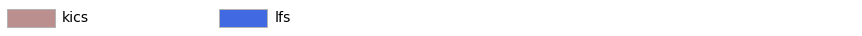

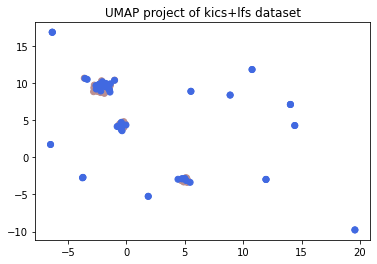

2 0.0 manhattan
UMAP(metric='manhattan', min_dist=0.0, n_neighbors=2, verbose=True)
Wed Dec 21 09:39:38 2022 Construct fuzzy simplicial set
Wed Dec 21 09:39:38 2022 Finding Nearest Neighbors
Wed Dec 21 09:39:38 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:39:38 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:39:39 2022 Finished embedding
['kics' 'lfs']


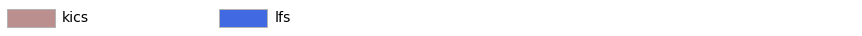

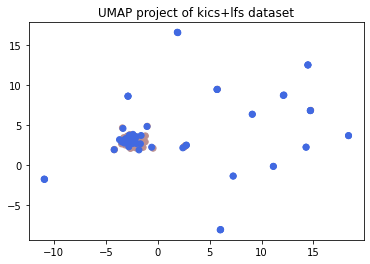

2 0.0 chebyshev
UMAP(metric='chebyshev', min_dist=0.0, n_neighbors=2, verbose=True)
Wed Dec 21 09:39:39 2022 Construct fuzzy simplicial set
Wed Dec 21 09:39:39 2022 Finding Nearest Neighbors
Wed Dec 21 09:39:39 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:39:39 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:39:40 2022 Finished embedding
['kics' 'lfs']


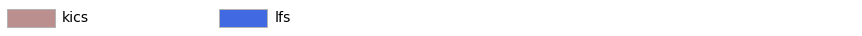

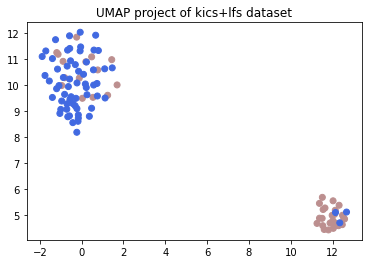

2 0.0 jaccard
UMAP(angular_rp_forest=True, metric='jaccard', min_dist=0.0, n_neighbors=2, verbose=True)
Wed Dec 21 09:39:40 2022 Construct fuzzy simplicial set
Wed Dec 21 09:39:40 2022 Finding Nearest Neighbors
Wed Dec 21 09:39:40 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:39:40 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:39:42 2022 Finished embedding
['kics' 'lfs']


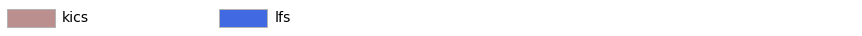

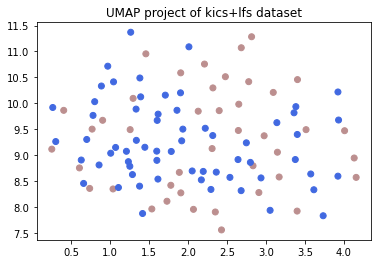

2 0.1 euclidean
UMAP(n_neighbors=2, verbose=True)
Wed Dec 21 09:39:42 2022 Construct fuzzy simplicial set
Wed Dec 21 09:39:42 2022 Finding Nearest Neighbors
Wed Dec 21 09:39:42 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:39:42 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:39:43 2022 Finished embedding
['kics' 'lfs']


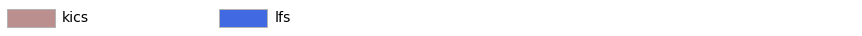

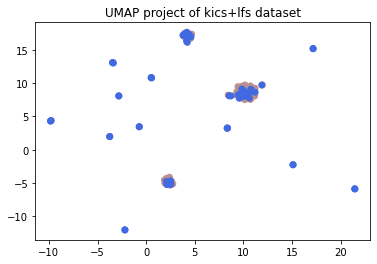

2 0.1 manhattan
UMAP(metric='manhattan', n_neighbors=2, verbose=True)
Wed Dec 21 09:39:43 2022 Construct fuzzy simplicial set
Wed Dec 21 09:39:43 2022 Finding Nearest Neighbors
Wed Dec 21 09:39:43 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:39:43 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:39:44 2022 Finished embedding
['kics' 'lfs']


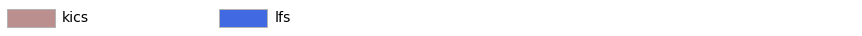

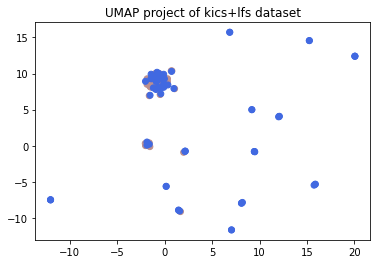

2 0.1 chebyshev
UMAP(metric='chebyshev', n_neighbors=2, verbose=True)
Wed Dec 21 09:39:44 2022 Construct fuzzy simplicial set
Wed Dec 21 09:39:44 2022 Finding Nearest Neighbors
Wed Dec 21 09:39:44 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:39:44 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:39:45 2022 Finished embedding
['kics' 'lfs']


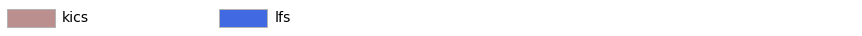

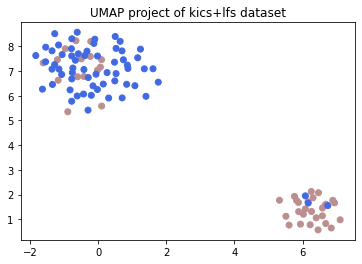

2 0.1 jaccard
UMAP(angular_rp_forest=True, metric='jaccard', n_neighbors=2, verbose=True)
Wed Dec 21 09:39:45 2022 Construct fuzzy simplicial set
Wed Dec 21 09:39:45 2022 Finding Nearest Neighbors
Wed Dec 21 09:39:45 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:39:45 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:39:46 2022 Finished embedding
['kics' 'lfs']


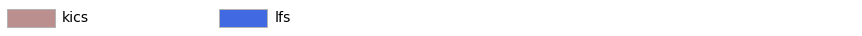

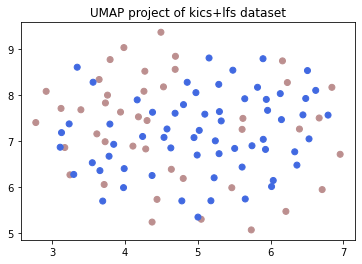

2 0.25 euclidean
UMAP(min_dist=0.25, n_neighbors=2, verbose=True)
Wed Dec 21 09:39:46 2022 Construct fuzzy simplicial set
Wed Dec 21 09:39:47 2022 Finding Nearest Neighbors
Wed Dec 21 09:39:47 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:39:47 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:39:47 2022 Finished embedding
['kics' 'lfs']


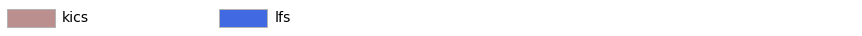

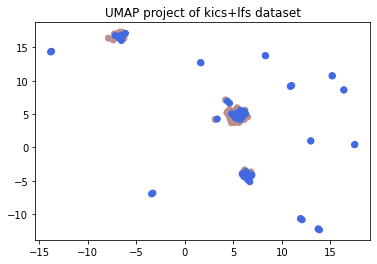

2 0.25 manhattan
UMAP(metric='manhattan', min_dist=0.25, n_neighbors=2, verbose=True)
Wed Dec 21 09:39:48 2022 Construct fuzzy simplicial set
Wed Dec 21 09:39:48 2022 Finding Nearest Neighbors
Wed Dec 21 09:39:48 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:39:48 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:39:49 2022 Finished embedding
['kics' 'lfs']


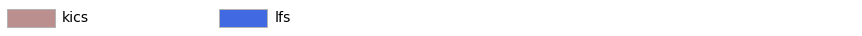

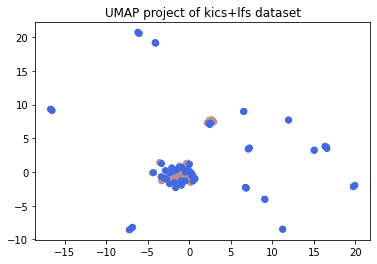

2 0.25 chebyshev
UMAP(metric='chebyshev', min_dist=0.25, n_neighbors=2, verbose=True)
Wed Dec 21 09:39:49 2022 Construct fuzzy simplicial set
Wed Dec 21 09:39:49 2022 Finding Nearest Neighbors
Wed Dec 21 09:39:49 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:39:49 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:39:50 2022 Finished embedding
['kics' 'lfs']


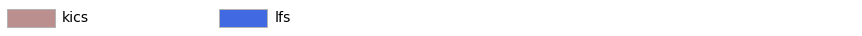

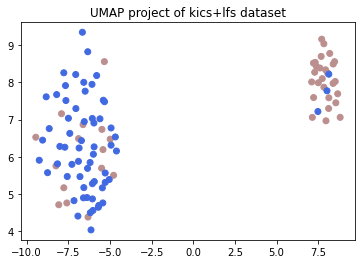

2 0.25 jaccard
UMAP(angular_rp_forest=True, metric='jaccard', min_dist=0.25, n_neighbors=2, verbose=True)
Wed Dec 21 09:39:50 2022 Construct fuzzy simplicial set
Wed Dec 21 09:39:50 2022 Finding Nearest Neighbors
Wed Dec 21 09:39:50 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:39:50 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:39:51 2022 Finished embedding
['kics' 'lfs']


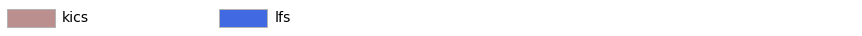

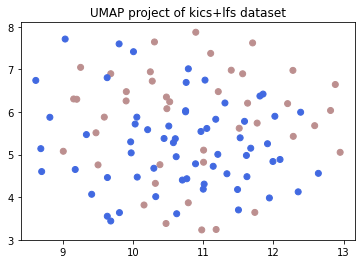

2 0.5 euclidean
UMAP(min_dist=0.5, n_neighbors=2, verbose=True)
Wed Dec 21 09:39:51 2022 Construct fuzzy simplicial set
Wed Dec 21 09:39:51 2022 Finding Nearest Neighbors
Wed Dec 21 09:39:51 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:39:51 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:39:53 2022 Finished embedding
['kics' 'lfs']


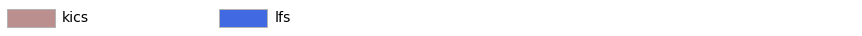

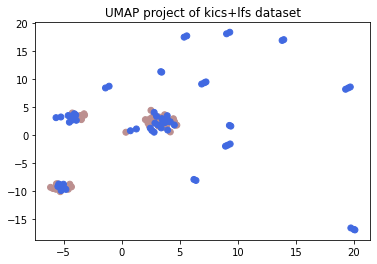

2 0.5 manhattan
UMAP(metric='manhattan', min_dist=0.5, n_neighbors=2, verbose=True)
Wed Dec 21 09:39:53 2022 Construct fuzzy simplicial set
Wed Dec 21 09:39:53 2022 Finding Nearest Neighbors
Wed Dec 21 09:39:53 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:39:53 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:39:54 2022 Finished embedding
['kics' 'lfs']


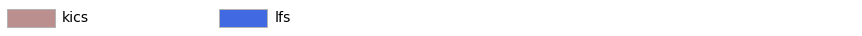

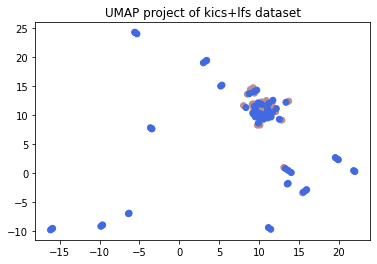

2 0.5 chebyshev
UMAP(metric='chebyshev', min_dist=0.5, n_neighbors=2, verbose=True)
Wed Dec 21 09:39:54 2022 Construct fuzzy simplicial set
Wed Dec 21 09:39:54 2022 Finding Nearest Neighbors
Wed Dec 21 09:39:54 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:39:54 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:39:55 2022 Finished embedding
['kics' 'lfs']


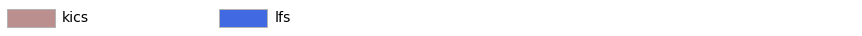

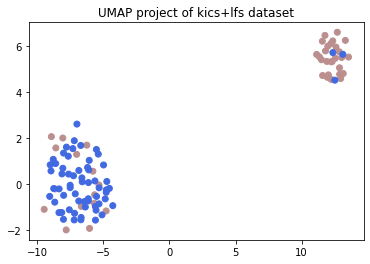

2 0.5 jaccard
UMAP(angular_rp_forest=True, metric='jaccard', min_dist=0.5, n_neighbors=2, verbose=True)
Wed Dec 21 09:39:55 2022 Construct fuzzy simplicial set
Wed Dec 21 09:39:55 2022 Finding Nearest Neighbors
Wed Dec 21 09:39:55 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:39:55 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:39:56 2022 Finished embedding
['kics' 'lfs']


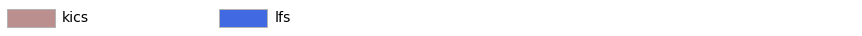

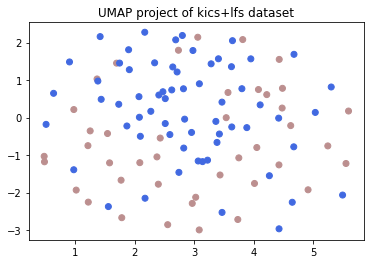

2 0.8 euclidean
UMAP(min_dist=0.8, n_neighbors=2, verbose=True)
Wed Dec 21 09:39:56 2022 Construct fuzzy simplicial set
Wed Dec 21 09:39:56 2022 Finding Nearest Neighbors
Wed Dec 21 09:39:56 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:39:56 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:39:57 2022 Finished embedding
['kics' 'lfs']


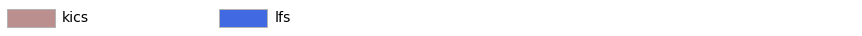

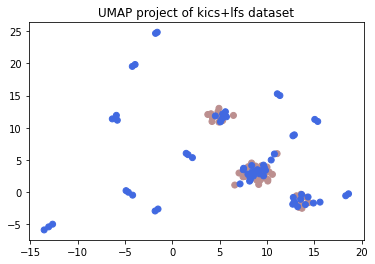

2 0.8 manhattan
UMAP(metric='manhattan', min_dist=0.8, n_neighbors=2, verbose=True)
Wed Dec 21 09:39:58 2022 Construct fuzzy simplicial set
Wed Dec 21 09:39:58 2022 Finding Nearest Neighbors
Wed Dec 21 09:39:58 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:39:58 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:39:59 2022 Finished embedding
['kics' 'lfs']


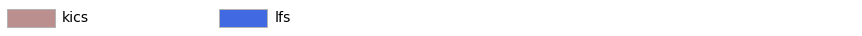

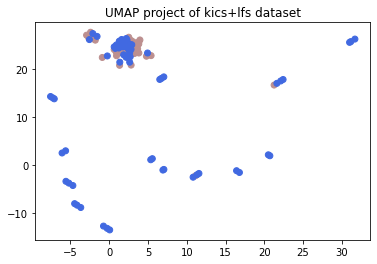

2 0.8 chebyshev
UMAP(metric='chebyshev', min_dist=0.8, n_neighbors=2, verbose=True)
Wed Dec 21 09:39:59 2022 Construct fuzzy simplicial set
Wed Dec 21 09:39:59 2022 Finding Nearest Neighbors
Wed Dec 21 09:39:59 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:39:59 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:40:00 2022 Finished embedding
['kics' 'lfs']


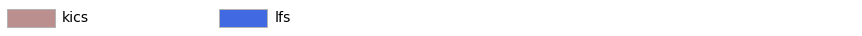

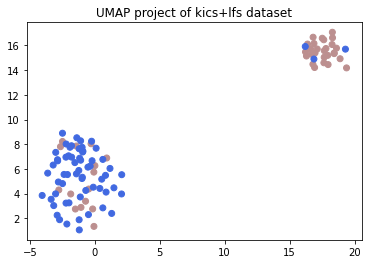

2 0.8 jaccard
UMAP(angular_rp_forest=True, metric='jaccard', min_dist=0.8, n_neighbors=2, verbose=True)
Wed Dec 21 09:40:00 2022 Construct fuzzy simplicial set
Wed Dec 21 09:40:00 2022 Finding Nearest Neighbors
Wed Dec 21 09:40:00 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:40:00 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:40:01 2022 Finished embedding
['kics' 'lfs']


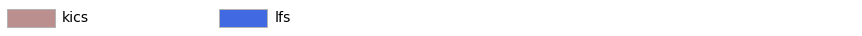

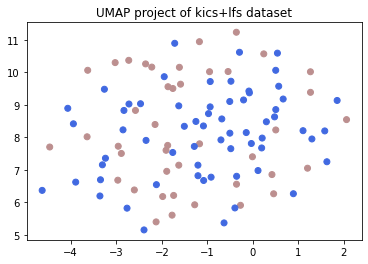

2 0.99 euclidean
UMAP(min_dist=0.99, n_neighbors=2, verbose=True)
Wed Dec 21 09:40:02 2022 Construct fuzzy simplicial set
Wed Dec 21 09:40:02 2022 Finding Nearest Neighbors
Wed Dec 21 09:40:02 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:40:02 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:40:03 2022 Finished embedding
['kics' 'lfs']


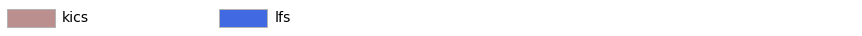

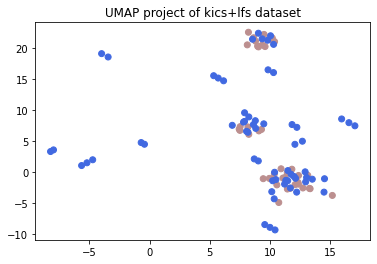

2 0.99 manhattan
UMAP(metric='manhattan', min_dist=0.99, n_neighbors=2, verbose=True)
Wed Dec 21 09:40:03 2022 Construct fuzzy simplicial set
Wed Dec 21 09:40:03 2022 Finding Nearest Neighbors
Wed Dec 21 09:40:03 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:40:03 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:40:04 2022 Finished embedding
['kics' 'lfs']


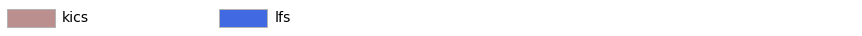

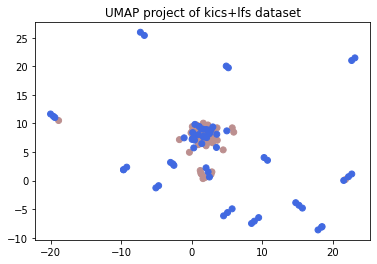

2 0.99 chebyshev
UMAP(metric='chebyshev', min_dist=0.99, n_neighbors=2, verbose=True)
Wed Dec 21 09:40:04 2022 Construct fuzzy simplicial set
Wed Dec 21 09:40:04 2022 Finding Nearest Neighbors
Wed Dec 21 09:40:04 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:40:04 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:40:05 2022 Finished embedding
['kics' 'lfs']


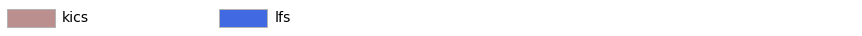

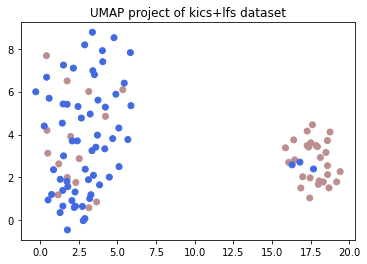

2 0.99 jaccard
UMAP(angular_rp_forest=True, metric='jaccard', min_dist=0.99, n_neighbors=2, verbose=True)
Wed Dec 21 09:40:05 2022 Construct fuzzy simplicial set
Wed Dec 21 09:40:06 2022 Finding Nearest Neighbors
Wed Dec 21 09:40:06 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:40:06 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:40:07 2022 Finished embedding
['kics' 'lfs']


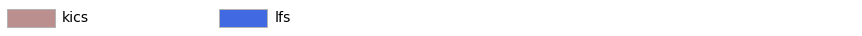

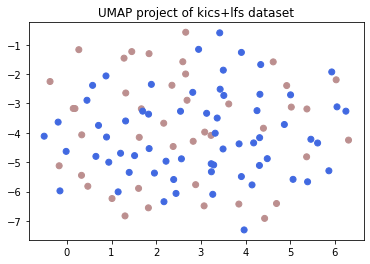

5 0.0 euclidean
UMAP(min_dist=0.0, n_neighbors=5, verbose=True)
Wed Dec 21 09:40:07 2022 Construct fuzzy simplicial set
Wed Dec 21 09:40:07 2022 Finding Nearest Neighbors
Wed Dec 21 09:40:07 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:40:07 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:40:09 2022 Finished embedding
['kics' 'lfs']


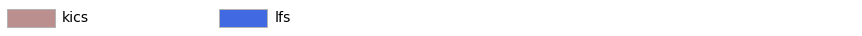

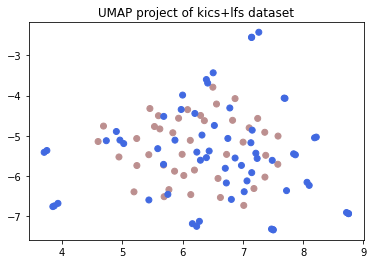

5 0.0 manhattan
UMAP(metric='manhattan', min_dist=0.0, n_neighbors=5, verbose=True)
Wed Dec 21 09:40:09 2022 Construct fuzzy simplicial set
Wed Dec 21 09:40:09 2022 Finding Nearest Neighbors
Wed Dec 21 09:40:09 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:40:09 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:40:10 2022 Finished embedding
['kics' 'lfs']


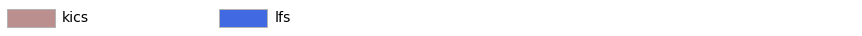

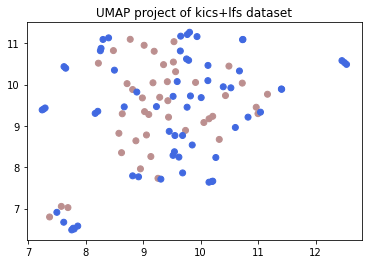

5 0.0 chebyshev
UMAP(metric='chebyshev', min_dist=0.0, n_neighbors=5, verbose=True)
Wed Dec 21 09:40:10 2022 Construct fuzzy simplicial set
Wed Dec 21 09:40:10 2022 Finding Nearest Neighbors
Wed Dec 21 09:40:10 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:40:10 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:40:12 2022 Finished embedding
['kics' 'lfs']


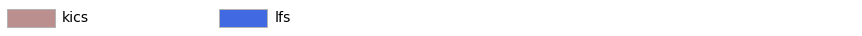

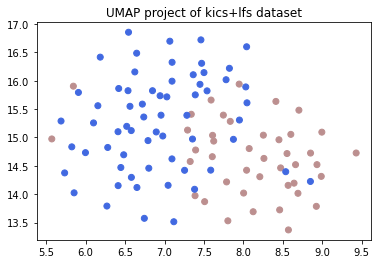

5 0.0 jaccard
UMAP(angular_rp_forest=True, metric='jaccard', min_dist=0.0, n_neighbors=5, verbose=True)
Wed Dec 21 09:40:12 2022 Construct fuzzy simplicial set
Wed Dec 21 09:40:12 2022 Finding Nearest Neighbors
Wed Dec 21 09:40:12 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:40:12 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:40:13 2022 Finished embedding
['kics' 'lfs']


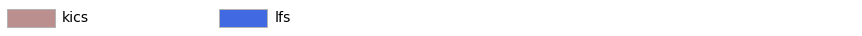

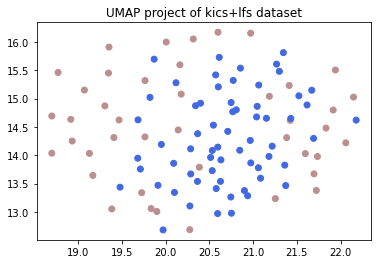

5 0.1 euclidean
UMAP(n_neighbors=5, verbose=True)
Wed Dec 21 09:40:14 2022 Construct fuzzy simplicial set
Wed Dec 21 09:40:14 2022 Finding Nearest Neighbors
Wed Dec 21 09:40:14 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:40:14 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:40:15 2022 Finished embedding
['kics' 'lfs']


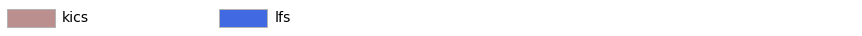

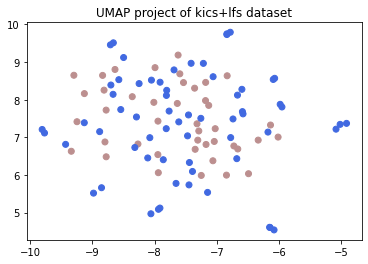

5 0.1 manhattan
UMAP(metric='manhattan', n_neighbors=5, verbose=True)
Wed Dec 21 09:40:15 2022 Construct fuzzy simplicial set
Wed Dec 21 09:40:15 2022 Finding Nearest Neighbors
Wed Dec 21 09:40:15 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:40:15 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:40:16 2022 Finished embedding
['kics' 'lfs']


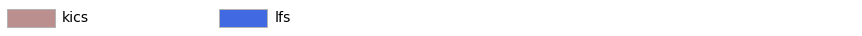

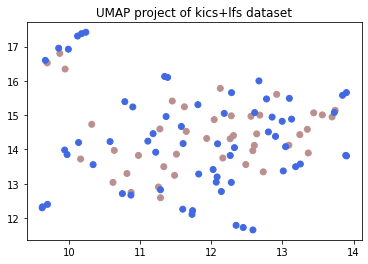

5 0.1 chebyshev
UMAP(metric='chebyshev', n_neighbors=5, verbose=True)
Wed Dec 21 09:40:16 2022 Construct fuzzy simplicial set
Wed Dec 21 09:40:16 2022 Finding Nearest Neighbors
Wed Dec 21 09:40:16 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:40:16 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:40:18 2022 Finished embedding
['kics' 'lfs']


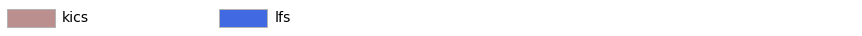

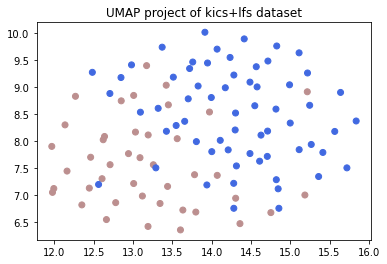

5 0.1 jaccard
UMAP(angular_rp_forest=True, metric='jaccard', n_neighbors=5, verbose=True)
Wed Dec 21 09:40:18 2022 Construct fuzzy simplicial set
Wed Dec 21 09:40:18 2022 Finding Nearest Neighbors
Wed Dec 21 09:40:18 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:40:18 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:40:19 2022 Finished embedding
['kics' 'lfs']


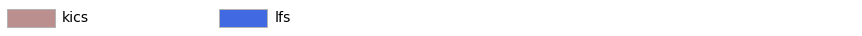

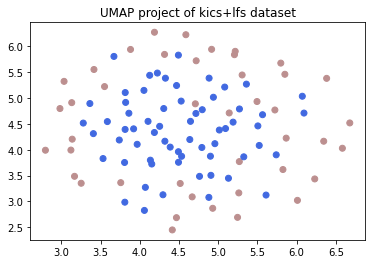

5 0.25 euclidean
UMAP(min_dist=0.25, n_neighbors=5, verbose=True)
Wed Dec 21 09:40:19 2022 Construct fuzzy simplicial set
Wed Dec 21 09:40:19 2022 Finding Nearest Neighbors
Wed Dec 21 09:40:19 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:40:19 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:40:20 2022 Finished embedding
['kics' 'lfs']


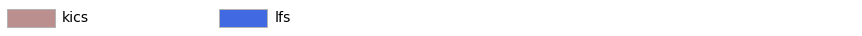

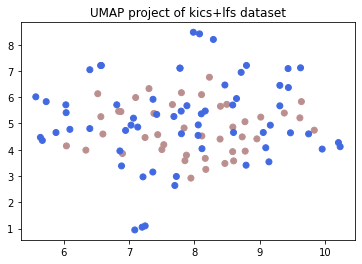

5 0.25 manhattan
UMAP(metric='manhattan', min_dist=0.25, n_neighbors=5, verbose=True)
Wed Dec 21 09:40:20 2022 Construct fuzzy simplicial set
Wed Dec 21 09:40:20 2022 Finding Nearest Neighbors
Wed Dec 21 09:40:20 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:40:20 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:40:22 2022 Finished embedding
['kics' 'lfs']


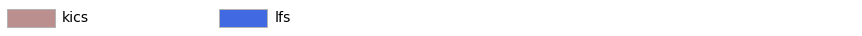

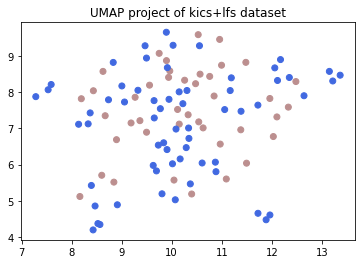

5 0.25 chebyshev
UMAP(metric='chebyshev', min_dist=0.25, n_neighbors=5, verbose=True)
Wed Dec 21 09:40:22 2022 Construct fuzzy simplicial set
Wed Dec 21 09:40:22 2022 Finding Nearest Neighbors
Wed Dec 21 09:40:22 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:40:22 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:40:23 2022 Finished embedding
['kics' 'lfs']


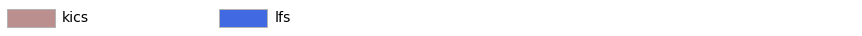

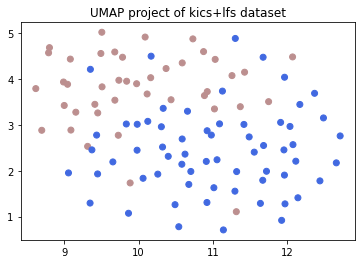

5 0.25 jaccard
UMAP(angular_rp_forest=True, metric='jaccard', min_dist=0.25, n_neighbors=5, verbose=True)
Wed Dec 21 09:40:24 2022 Construct fuzzy simplicial set
Wed Dec 21 09:40:24 2022 Finding Nearest Neighbors
Wed Dec 21 09:40:24 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:40:24 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:40:26 2022 Finished embedding
['kics' 'lfs']


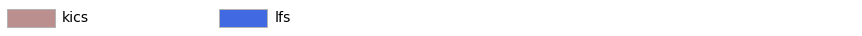

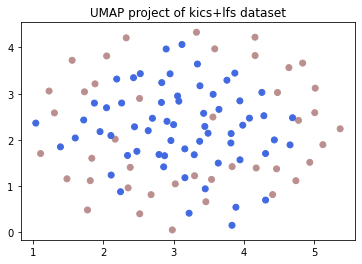

5 0.5 euclidean
UMAP(min_dist=0.5, n_neighbors=5, verbose=True)
Wed Dec 21 09:40:26 2022 Construct fuzzy simplicial set
Wed Dec 21 09:40:26 2022 Finding Nearest Neighbors
Wed Dec 21 09:40:26 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:40:26 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:40:28 2022 Finished embedding
['kics' 'lfs']


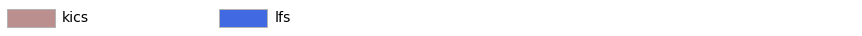

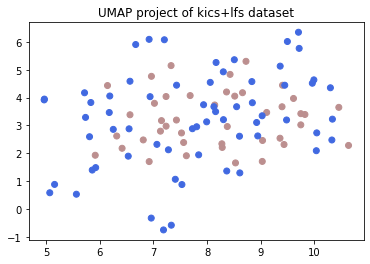

5 0.5 manhattan
UMAP(metric='manhattan', min_dist=0.5, n_neighbors=5, verbose=True)
Wed Dec 21 09:40:28 2022 Construct fuzzy simplicial set
Wed Dec 21 09:40:28 2022 Finding Nearest Neighbors
Wed Dec 21 09:40:28 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:40:28 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:40:29 2022 Finished embedding
['kics' 'lfs']


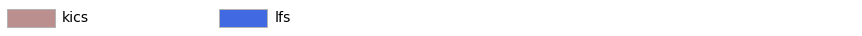

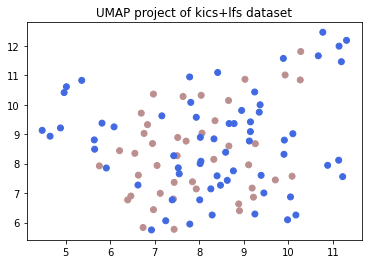

5 0.5 chebyshev
UMAP(metric='chebyshev', min_dist=0.5, n_neighbors=5, verbose=True)
Wed Dec 21 09:40:30 2022 Construct fuzzy simplicial set
Wed Dec 21 09:40:30 2022 Finding Nearest Neighbors
Wed Dec 21 09:40:30 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:40:30 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:40:31 2022 Finished embedding
['kics' 'lfs']


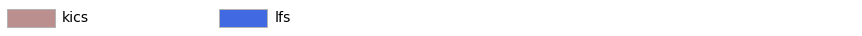

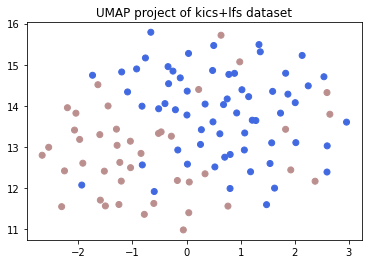

5 0.5 jaccard
UMAP(angular_rp_forest=True, metric='jaccard', min_dist=0.5, n_neighbors=5, verbose=True)
Wed Dec 21 09:40:31 2022 Construct fuzzy simplicial set
Wed Dec 21 09:40:31 2022 Finding Nearest Neighbors
Wed Dec 21 09:40:31 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:40:31 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:40:33 2022 Finished embedding
['kics' 'lfs']


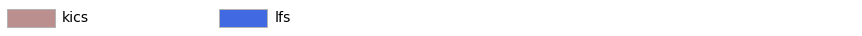

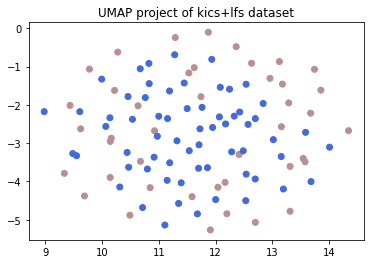

5 0.8 euclidean
UMAP(min_dist=0.8, n_neighbors=5, verbose=True)
Wed Dec 21 09:40:33 2022 Construct fuzzy simplicial set
Wed Dec 21 09:40:33 2022 Finding Nearest Neighbors
Wed Dec 21 09:40:33 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:40:33 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:40:34 2022 Finished embedding
['kics' 'lfs']


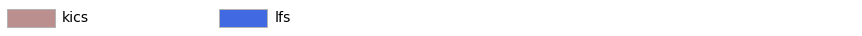

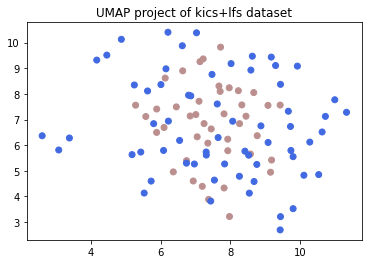

5 0.8 manhattan
UMAP(metric='manhattan', min_dist=0.8, n_neighbors=5, verbose=True)
Wed Dec 21 09:40:34 2022 Construct fuzzy simplicial set
Wed Dec 21 09:40:34 2022 Finding Nearest Neighbors
Wed Dec 21 09:40:34 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:40:34 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:40:35 2022 Finished embedding
['kics' 'lfs']


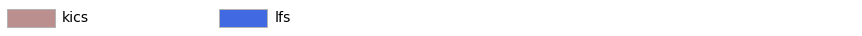

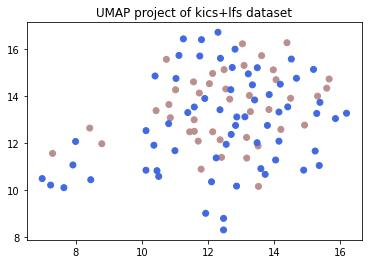

5 0.8 chebyshev
UMAP(metric='chebyshev', min_dist=0.8, n_neighbors=5, verbose=True)
Wed Dec 21 09:40:35 2022 Construct fuzzy simplicial set
Wed Dec 21 09:40:35 2022 Finding Nearest Neighbors
Wed Dec 21 09:40:35 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:40:35 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:40:37 2022 Finished embedding
['kics' 'lfs']


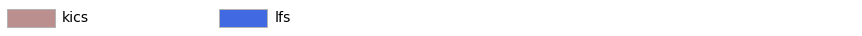

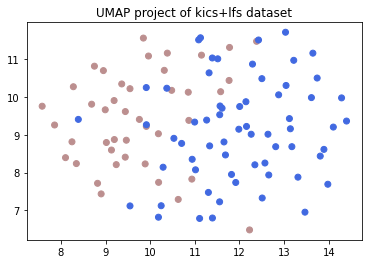

5 0.8 jaccard
UMAP(angular_rp_forest=True, metric='jaccard', min_dist=0.8, n_neighbors=5, verbose=True)
Wed Dec 21 09:40:37 2022 Construct fuzzy simplicial set
Wed Dec 21 09:40:37 2022 Finding Nearest Neighbors
Wed Dec 21 09:40:37 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:40:37 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:40:38 2022 Finished embedding
['kics' 'lfs']


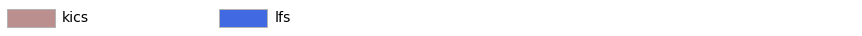

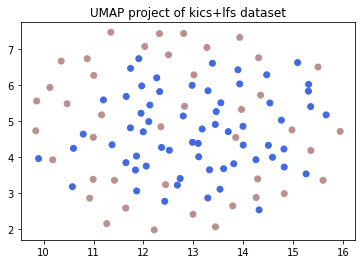

5 0.99 euclidean
UMAP(min_dist=0.99, n_neighbors=5, verbose=True)
Wed Dec 21 09:40:38 2022 Construct fuzzy simplicial set
Wed Dec 21 09:40:39 2022 Finding Nearest Neighbors
Wed Dec 21 09:40:39 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:40:39 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:40:40 2022 Finished embedding
['kics' 'lfs']


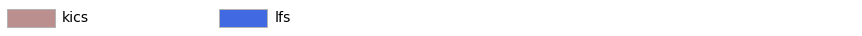

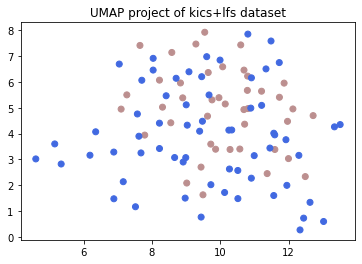

5 0.99 manhattan
UMAP(metric='manhattan', min_dist=0.99, n_neighbors=5, verbose=True)
Wed Dec 21 09:40:40 2022 Construct fuzzy simplicial set
Wed Dec 21 09:40:40 2022 Finding Nearest Neighbors
Wed Dec 21 09:40:40 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:40:40 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:40:41 2022 Finished embedding
['kics' 'lfs']


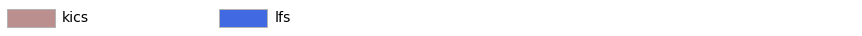

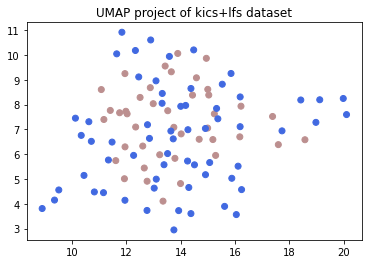

5 0.99 chebyshev
UMAP(metric='chebyshev', min_dist=0.99, n_neighbors=5, verbose=True)
Wed Dec 21 09:40:41 2022 Construct fuzzy simplicial set
Wed Dec 21 09:40:41 2022 Finding Nearest Neighbors
Wed Dec 21 09:40:41 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:40:41 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Dec 21 09:40:43 2022 Finished embedding
['kics' 'lfs']


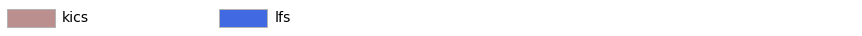

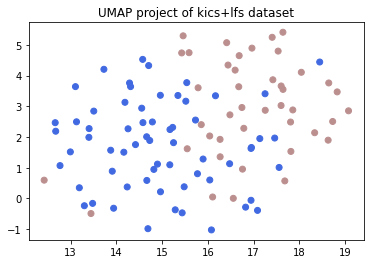

5 0.99 jaccard
UMAP(angular_rp_forest=True, metric='jaccard', min_dist=0.99, n_neighbors=5, verbose=True)
Wed Dec 21 09:40:43 2022 Construct fuzzy simplicial set
Wed Dec 21 09:40:43 2022 Finding Nearest Neighbors
Wed Dec 21 09:40:43 2022 Finished Nearest Neighbor Search
Wed Dec 21 09:40:43 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

In [ ]:
"""
LFS vs Kics Coloured UMAPS
"""
mergeMatrix = mergeMatrixAttempt1(kicsWindowFile, lfsWindowFile,'dataset')
mapABunchUmaps(mergeMatrix)

In [ ]:
"""
Age of onset of kics and lfs UMAP
"""
mergeMatrix = mergeMatrixAttempt1(kicsWindowFile, lfsWindowFile,'ageofonset')
mapABunchUmaps(mergeMatrix)

#0 means unaffected


In [ ]:
"""
Sex coloured UMAP
"""
mergeMatrix = mergeMatrixAttempt1(kicsWindowFile, lfsWindowFile,'Sex')
mapABunchUmaps(mergeMatrix)

In [ ]:
"""
Tissue type coloured UMAP
"""
mergeMatrix = mergeMatrixAttempt1(kicsWindowFile, lfsWindowFile,'tissue_type')
mapABunchUmaps(mergeMatrix)

In [ ]:
"""
Cancer type/diagnosis coloured UMAP
"""
mergeMatrix = mergeMatrixAttempt1(kicsWindowFile, lfsWindowFile,'cancer_diagnosis')
mapABunchUmaps(mergeMatrix)